- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack


from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.layers import Conv1D,GRU,TimeDistributed,MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling1D,ZeroPadding1D

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features=scaler.fit_transform(df_features)

# Select k-best features

In [5]:
#from sklearn.feature_selection import SelectKBest,f_classif
#k=[12,15,18,21,24,31]
df_features = SelectKBest(f_classif,k=12).fit_transform(df_features,mind_wandered_label)

In [6]:
participant_ids=participant_ids[:2193]

In [7]:
#participant_ids=participant_ids[:3300]

# Allknn undersampling

In [8]:
from imblearn.under_sampling import AllKNN
#df_features=df_features.values.reshape(-1, 1)
allknn = AllKNN()
df_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)

# SMOTEENN Oversampling

In [9]:
"""from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)"""

'from imblearn.combine import SMOTEENN\nsme = SMOTEENN(random_state=42)\ndf_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)'

In [10]:
mind_wandered_label.shape

(2193,)

# Data Reshape for conv1d

In [11]:
#df_features = df_features.to_numpy()
df_features=df_features.reshape((df_features.shape[0], df_features.shape[1], 1))
df_features.shape

(2193, 12, 1)

# AUROC

In [12]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

# Conv1d Model

A **ZeroPadding1D** layer is added after the input layer to add zeros at the beginning and end of each series. Zero-padding ensures that the convolution layer does not reduce the dimension of the output sequences.

We add a Conv1D layer. The first argument of Conv1D is the number of filters, which determine the number of features in the output. The second argument indicates the length of the 1D convolution window. The third argument is strides and represents the number of places to shift the convolution window. Lastly, though we haven't used it here, setting use_bias as True adds a bias value during the computation of an output feature. Here, the 1D convolution can be thought of as generating local MW models over a rolling window of Five time units.

From tensorflow doc: 

Padding: One of "valid", "same" or "causal" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. "causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order

In [13]:
def create_model(filters=64,kernel_size=5):
    model = Sequential([
    Conv1D(filters=filters, kernel_size=kernel_size,strides=1, activation='tanh',padding='causal', input_shape=(df_features.shape[1], 1)),
    ZeroPadding1D(padding=1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
    optimizer=SGD(lr=0.001)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])
    return model

In [14]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=50, batch_size=32, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [15]:

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None


parameters = {
        #'scaling__type_of_scaling': ['standard'],
        #'outlier__outlier_threshold': [0.0, 3.0],
        #'features__k': [12,15],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        'model__batch_size': [32, 48],#usually multiple of 8
        'model__epochs':[50,60],
        'model__filters':[8,16,32,64],
        'model__kernel_size':[3,5,7],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

# Estimator Pipeline
pipeline = Pipeline(
      [
        #('progress', GridSearchProgressHack(verbose=False)),
        #('scaling',  FeatureScalerTransformer()),
        #('outlier',  WinsorizationOutlierTransformer()),
        #('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        #('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
# Cross Validation Splitter
cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        #cv = 5,
        refit = 'roc_auc',
        verbose = 1)

search.fit(df_features, mind_wandered_label, groups=participant_ids)
#search.fit(df_features, mind_wandered_label)

df = pd.DataFrame(data=search.cv_results_)
    
    
if best_estimator is None:
    df_result = df
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    best_index = search.best_index_
else:
    df_result = df_result.append(df, ignore_index=True)
    if search.best_score_ > best_score:
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_  # todo this is only the index of this search

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 0.6948 - accuracy: 0.4747 - auc_roc: 0.4818
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5084 - auc_roc: 0.5146
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5121 - auc_roc: 0.5245
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4883 - auc_roc: 0.4936
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5327 - auc_roc: 0.5510
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5415 - auc_roc: 0.5750
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5443 - auc_roc: 0.5766
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5465 - auc_roc: 0.5839
Epoch 9/50

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.5352 - auc_roc: 0.6798
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5258 - auc_roc: 0.4808
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5179 - auc_roc: 0.4839
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.5145 - auc_roc: 0.4918
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5466 - auc_roc: 0.5285
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5435 - auc_roc: 0.5447
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5546 - auc_roc: 0.5578
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5489 - auc_roc: 0.5974
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7102 - accuracy: 0.4806 - auc_roc: 0.6254
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7094 - accuracy: 0.4830 - auc_roc: 0.3853
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.4820 - auc_roc: 0.4008
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.5153 - auc_roc: 0.4076
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.4931 - auc_roc: 0.4047
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.4978 - auc_roc: 0.4281
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7044 - accuracy: 0.5067 - auc_roc: 0.4065
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5200 - auc_roc: 0.4663
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7039 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6825 - accuracy: 0.5909 - auc_roc: 0.6269
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.6213 - auc_roc: 0.6461
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5869 - auc_roc: 0.6245
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.6073 - auc_roc: 0.6289
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.6021 - auc_roc: 0.6433
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.6180 - auc_roc: 0.6542
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.6099 - auc_roc: 0.6475
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.6342 - auc_roc: 0.6728
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6715 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.4289 - auc_roc: 0.6929
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.4616 - auc_roc: 0.4670
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.4765 - auc_roc: 0.4939
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.4812 - auc_roc: 0.5212
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.4894 - auc_roc: 0.5329
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5059 - auc_roc: 0.5478
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5180 - auc_roc: 0.5607
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5192 - auc_roc: 0.5760
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6752 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7035 - accuracy: 0.4714 - auc_roc: 0.6446
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.4610 - auc_roc: 0.3747
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7034 - accuracy: 0.4578 - auc_roc: 0.4075
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4871 - auc_roc: 0.4182
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4857 - auc_roc: 0.4277
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.4928 - auc_roc: 0.4342
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.4624 - auc_roc: 0.4550
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4841 - auc_roc: 0.4728
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.6317 - auc_roc: 0.7222
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6694 - accuracy: 0.6619 - auc_roc: 0.6998
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.6317 - auc_roc: 0.6693
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6691 - auc_roc: 0.7199
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.6663 - auc_roc: 0.7077
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6668 - auc_roc: 0.7092
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6595 - auc_roc: 0.7193
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6901 - auc_roc: 0.7396
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6574 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6981 - accuracy: 0.4968 - auc_roc: 0.6708
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4906 - auc_roc: 0.4487
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.4881 - auc_roc: 0.4918
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.4872 - auc_roc: 0.4836
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5107 - auc_roc: 0.4944
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.5252 - auc_roc: 0.5182
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5239 - auc_roc: 0.5257
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5491 - auc_roc: 0.5510
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6889 - accuracy: 0.5448 - auc_roc: 0.6882
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5452 - auc_roc: 0.5109
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5260 - auc_roc: 0.5612
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5412 - auc_roc: 0.5627
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5453 - auc_roc: 0.5634
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5627 - auc_roc: 0.5696
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5760 - auc_roc: 0.6046
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5741 - auc_roc: 0.6005
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6836 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6734 - accuracy: 0.5313 - auc_roc: 0.6989
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.5188 - auc_roc: 0.6416
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.5531 - auc_roc: 0.6653
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.5391 - auc_roc: 0.6661
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6640 - accuracy: 0.5241 - auc_roc: 0.6730
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.5494 - auc_roc: 0.7004
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6495 - accuracy: 0.5673 - auc_roc: 0.6958
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6544 - accuracy: 0.5595 - auc_roc: 0.7068
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6527 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7233 - accuracy: 0.4877 - auc_roc: 0.6684
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.4922 - auc_roc: 0.4309
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7122 - accuracy: 0.4988 - auc_roc: 0.4425
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.5090 - auc_roc: 0.4778
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.4757 - auc_roc: 0.4899
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5061 - auc_roc: 0.5034
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5433 - auc_roc: 0.5390
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5009 - auc_roc: 0.5813
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6756 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6946 - accuracy: 0.5539 - auc_roc: 0.6775
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5818 - auc_roc: 0.5014
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5925 - auc_roc: 0.4854
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5719 - auc_roc: 0.4935
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5674 - auc_roc: 0.5231
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5797 - auc_roc: 0.5084
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5836 - auc_roc: 0.5353
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5888 - auc_roc: 0.5497
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6864 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 0.6853 - accuracy: 0.5479 - auc_roc: 0.7105
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5620 - auc_roc: 0.6811
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5730 - auc_roc: 0.6848
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5888 - auc_roc: 0.6789
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.6014 - auc_roc: 0.7008
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5884 - auc_roc: 0.6830
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6092 - auc_roc: 0.6966
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.6188 - auc_roc: 0.7022
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6977 - accuracy: 0.4970 - auc_roc: 0.6823
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.5225 - auc_roc: 0.4862
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.5166 - auc_roc: 0.4964
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5256 - auc_roc: 0.5090
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5277 - auc_roc: 0.5150
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5534 - auc_roc: 0.5346
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5763 - auc_roc: 0.5453
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5515 - auc_roc: 0.5421
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6844 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7034 - accuracy: 0.5041 - auc_roc: 0.6355
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5340 - auc_roc: 0.4393
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.5390 - auc_roc: 0.4530
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.5219 - auc_roc: 0.4634
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.5183 - auc_roc: 0.4546
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.5262 - auc_roc: 0.4658
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5336 - auc_roc: 0.4733
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5519 - auc_roc: 0.4842
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6727 - accuracy: 0.6182 - auc_roc: 0.6709
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6704 - accuracy: 0.6215 - auc_roc: 0.6871
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6613 - auc_roc: 0.7034
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.6587 - auc_roc: 0.6952
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6467 - auc_roc: 0.6914
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6549 - auc_roc: 0.7146
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6699 - auc_roc: 0.7147
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6649 - auc_roc: 0.7211
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6611 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6986 - accuracy: 0.5227 - auc_roc: 0.6573
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5358 - auc_roc: 0.4186
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.5358 - auc_roc: 0.4043
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.5426 - auc_roc: 0.4398
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.5392 - auc_roc: 0.4202
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.5457 - auc_roc: 0.4420
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.5600 - auc_roc: 0.4397
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.5583 - auc_roc: 0.4443
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7210 - accuracy: 0.3631 - auc_roc: 0.5623
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7203 - accuracy: 0.3686 - auc_roc: 0.2507
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7198 - accuracy: 0.3737 - auc_roc: 0.2569
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7214 - accuracy: 0.3774 - auc_roc: 0.2622
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7168 - accuracy: 0.4017 - auc_roc: 0.2714
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7195 - accuracy: 0.3777 - auc_roc: 0.2500
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7184 - accuracy: 0.3875 - auc_roc: 0.2603
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7165 - accuracy: 0.4004 - auc_roc: 0.2548
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7147 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6777 - accuracy: 0.6102 - auc_roc: 0.6696
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.6051 - auc_roc: 0.6385
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.6266 - auc_roc: 0.6607
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.6407 - auc_roc: 0.6816
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6712 - accuracy: 0.6291 - auc_roc: 0.6734
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.6587 - auc_roc: 0.6910
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.6602 - auc_roc: 0.7102
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6602 - auc_roc: 0.7069
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6622 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6469 - accuracy: 0.6691 - auc_roc: 0.7444
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6790 - auc_roc: 0.7234
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6395 - accuracy: 0.6915 - auc_roc: 0.7293
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6736 - auc_roc: 0.7128
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.7102 - auc_roc: 0.7525
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.6914 - auc_roc: 0.7301
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6780 - auc_roc: 0.7210
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6926 - auc_roc: 0.7347
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6258 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7025 - accuracy: 0.4777 - auc_roc: 0.6644
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.4641 - auc_roc: 0.4405
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.4648 - auc_roc: 0.4396
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4771 - auc_roc: 0.4708
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4968 - auc_roc: 0.5115
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5130 - auc_roc: 0.5100
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5416 - auc_roc: 0.5453
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5409 - auc_roc: 0.5583
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6975 - accuracy: 0.5349 - auc_roc: 0.6760
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.5465 - auc_roc: 0.4306
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5562 - auc_roc: 0.4600
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5454 - auc_roc: 0.4468
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5694 - auc_roc: 0.4820
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5884 - auc_roc: 0.4955
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.6033 - auc_roc: 0.5144
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5950 - auc_roc: 0.5369
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6841 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6463 - accuracy: 0.5931 - auc_roc: 0.7320
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.6227 - auc_roc: 0.7148
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6380 - accuracy: 0.6146 - auc_roc: 0.7230
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.6035 - auc_roc: 0.6922
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6406 - accuracy: 0.6093 - auc_roc: 0.7070
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6337 - accuracy: 0.6257 - auc_roc: 0.7184
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6258 - accuracy: 0.6448 - auc_roc: 0.7317
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.6266 - auc_roc: 0.7218
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6266 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6883 - accuracy: 0.5087 - auc_roc: 0.7193
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5230 - auc_roc: 0.5991
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5468 - auc_roc: 0.6316
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.5837 - auc_roc: 0.6563
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5998 - auc_roc: 0.6803
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.6243 - auc_roc: 0.7151
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6219 - auc_roc: 0.7135
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6721 - auc_roc: 0.7591
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6645 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7169 - accuracy: 0.4433 - auc_roc: 0.6328
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7148 - accuracy: 0.4537 - auc_roc: 0.3317
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.4702 - auc_roc: 0.3029
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.4684 - auc_roc: 0.3421
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7123 - accuracy: 0.4747 - auc_roc: 0.3039
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.4840 - auc_roc: 0.3142
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7134 - accuracy: 0.4578 - auc_roc: 0.3279
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7152 - accuracy: 0.4463 - auc_roc: 0.3165
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7093 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7045 - accuracy: 0.3524 - auc_roc: 0.5826
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.3712 - auc_roc: 0.3380
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.3896 - auc_roc: 0.3617
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.4342 - auc_roc: 0.4064
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4725 - auc_roc: 0.4430
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.4863 - auc_roc: 0.4870
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5314 - auc_roc: 0.5501
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5401 - auc_roc: 0.5699
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7013 - accuracy: 0.4341 - auc_roc: 0.6687
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.4373 - auc_roc: 0.4410
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4642 - auc_roc: 0.4684
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4744 - auc_roc: 0.4908
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5205 - auc_roc: 0.5390
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6915 - accuracy: 0.5036 - auc_roc: 0.5104
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5513 - auc_roc: 0.5651
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5605 - auc_roc: 0.5852
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6830 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6842 - accuracy: 0.4854 - auc_roc: 0.7038
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.4942 - auc_roc: 0.5520
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6742 - accuracy: 0.5113 - auc_roc: 0.5584
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.5442 - auc_roc: 0.5843
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6690 - accuracy: 0.5521 - auc_roc: 0.6139
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.5763 - auc_roc: 0.6277
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6083 - auc_roc: 0.6688
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6575 - accuracy: 0.6173 - auc_roc: 0.6602
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6613 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6918 - accuracy: 0.4912 - auc_roc: 0.7173
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5239 - auc_roc: 0.5709
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5574 - auc_roc: 0.6047
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5983 - auc_roc: 0.6164
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6835 - accuracy: 0.6329 - auc_roc: 0.6411
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6798 - accuracy: 0.6452 - auc_roc: 0.6615
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6791 - accuracy: 0.6601 - auc_roc: 0.6625
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.6760 - auc_roc: 0.6827
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6773 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6785 - accuracy: 0.5457 - auc_roc: 0.7159
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.5625 - auc_roc: 0.6221
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5603 - auc_roc: 0.6186
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6736 - accuracy: 0.5612 - auc_roc: 0.6247
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5694 - auc_roc: 0.6543
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6717 - accuracy: 0.5704 - auc_roc: 0.6249
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.5870 - auc_roc: 0.6628
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.5886 - auc_roc: 0.6632
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6626 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 575us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7071 - accuracy: 0.4103 - auc_roc: 0.6567
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.4324 - auc_roc: 0.3923
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.4025 - auc_roc: 0.3759
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.4204 - auc_roc: 0.4302
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4060 - auc_roc: 0.4432
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4566 - auc_roc: 0.4819
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.4304 - auc_roc: 0.4490
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4648 - auc_roc: 0.4929
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6956 - accuracy: 0.4676 - auc_roc: 0.6987
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4863 - auc_roc: 0.5241
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5177 - auc_roc: 0.5619
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5344 - auc_roc: 0.5812
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5727 - auc_roc: 0.6416
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5865 - auc_roc: 0.6409
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5861 - auc_roc: 0.6346
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.6237 - auc_roc: 0.6796
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6795 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6796 - accuracy: 0.6089 - auc_roc: 0.7216
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.6047 - auc_roc: 0.6502
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6769 - accuracy: 0.6139 - auc_roc: 0.6486
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.6345 - auc_roc: 0.6900
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6429 - auc_roc: 0.6769
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.6617 - auc_roc: 0.7074
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6743 - auc_roc: 0.7343
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6624 - auc_roc: 0.7068
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6604 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7063 - accuracy: 0.4451 - auc_roc: 0.6763
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7024 - accuracy: 0.4672 - auc_roc: 0.3292
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4733 - auc_roc: 0.3549
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6992 - accuracy: 0.5086 - auc_roc: 0.3802
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5248 - auc_roc: 0.4155
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5433 - auc_roc: 0.4923
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5506 - auc_roc: 0.5394
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5417 - auc_roc: 0.5667
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.5935 - auc_roc: 0.7259
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5956 - auc_roc: 0.6501
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6737 - accuracy: 0.6117 - auc_roc: 0.6765
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6114 - auc_roc: 0.6792
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6235 - auc_roc: 0.6904
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6657 - accuracy: 0.6301 - auc_roc: 0.6966
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6432 - auc_roc: 0.6990
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6538 - auc_roc: 0.6949
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6613 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.4695 - auc_roc: 0.6833
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.4741 - auc_roc: 0.4667
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5102 - auc_roc: 0.5335
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5385 - auc_roc: 0.5718
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5855 - auc_roc: 0.6391
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5947 - auc_roc: 0.6336
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6760 - accuracy: 0.6339 - auc_roc: 0.6896
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.6503 - auc_roc: 0.6998
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6707 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6969 - accuracy: 0.4559 - auc_roc: 0.6974
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4751 - auc_roc: 0.5337
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.4991 - auc_roc: 0.5991
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5074 - auc_roc: 0.6020
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5463 - auc_roc: 0.6548
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.6053 - auc_roc: 0.7092
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.6087 - auc_roc: 0.6841
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.6411 - auc_roc: 0.7154
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7194 - accuracy: 0.3214 - auc_roc: 0.6410
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7151 - accuracy: 0.3426 - auc_roc: 0.2643
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.3526 - auc_roc: 0.2788
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.3673 - auc_roc: 0.2877
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.3708 - auc_roc: 0.2977
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.3948 - auc_roc: 0.3294
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7018 - accuracy: 0.4031 - auc_roc: 0.3664
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.4323 - auc_roc: 0.3903
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6968 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 3ms/step - loss: 0.6757 - accuracy: 0.6225 - auc_roc: 0.7327
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.6262 - auc_roc: 0.6479
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.6259 - auc_roc: 0.6503
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6689 - accuracy: 0.6364 - auc_roc: 0.6649
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.6379 - auc_roc: 0.6760
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6672 - accuracy: 0.6335 - auc_roc: 0.6677
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6614 - accuracy: 0.6565 - auc_roc: 0.6913
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6606 - accuracy: 0.6574 - auc_roc: 0.6880
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7082 - accuracy: 0.3892 - auc_roc: 0.6700
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7041 - accuracy: 0.3923 - auc_roc: 0.3664
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.7025 - accuracy: 0.4103 - auc_roc: 0.3749
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6978 - accuracy: 0.4445 - auc_roc: 0.4196
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.4613 - auc_roc: 0.4368
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.4879 - auc_roc: 0.4918
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5046 - auc_roc: 0.5013
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5132 - auc_roc: 0.5400
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6821 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.5975 - auc_roc: 0.7302
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6244 - auc_roc: 0.7012
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.6378 - auc_roc: 0.7120
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.6333 - auc_roc: 0.7042
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6396 - auc_roc: 0.7046
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6517 - accuracy: 0.6444 - auc_roc: 0.7034
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.6417 - auc_roc: 0.7055
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6446 - auc_roc: 0.7088
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6502 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6879 - accuracy: 0.6160 - auc_roc: 0.6879
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.6074 - auc_roc: 0.5887
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.6258 - auc_roc: 0.5941
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.6257 - auc_roc: 0.6047
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.6297 - auc_roc: 0.6472
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.6365 - auc_roc: 0.6383
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.6248 - auc_roc: 0.6224
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6793 - accuracy: 0.6444 - auc_roc: 0.6449
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6775 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6954 - accuracy: 0.5191 - auc_roc: 0.6894
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5427 - auc_roc: 0.5397
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5461 - auc_roc: 0.5500
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5673 - auc_roc: 0.5925
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5816 - auc_roc: 0.5952
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6828 - accuracy: 0.5997 - auc_roc: 0.6162
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6130 - auc_roc: 0.6465
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.6373 - auc_roc: 0.6637
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6750 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6852 - accuracy: 0.5025 - auc_roc: 0.7150
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6778 - accuracy: 0.5132 - auc_roc: 0.6571
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.5086 - auc_roc: 0.6724
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5293 - auc_roc: 0.6884
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6732 - accuracy: 0.5178 - auc_roc: 0.6945
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.5391 - auc_roc: 0.7060
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.5778 - auc_roc: 0.7406
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.5641 - auc_roc: 0.7068
Epoch 9/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6625 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6849 - accuracy: 0.5330 - auc_roc: 0.7269
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.5482 - auc_roc: 0.6085
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.5461 - auc_roc: 0.6216
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5541 - auc_roc: 0.6679
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.5696 - auc_roc: 0.6900
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.5856 - auc_roc: 0.6925
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.5872 - auc_roc: 0.7304
Epoch 8/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6565 - accuracy: 0.6009 - auc_roc: 0.7234
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6560 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5442 - auc_roc: 0.6958
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5426 - auc_roc: 0.5352
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5563 - auc_roc: 0.5511
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.5668 - auc_roc: 0.5674
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.5944 - auc_roc: 0.5996
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.6128 - auc_roc: 0.6108
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.6138 - auc_roc: 0.6231
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6062 - auc_roc: 0.6087
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7056 - accuracy: 0.3922 - auc_roc: 0.6544
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7014 - accuracy: 0.4269 - auc_roc: 0.3192
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.4327 - auc_roc: 0.3172
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.4555 - auc_roc: 0.3383
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6964 - accuracy: 0.4962 - auc_roc: 0.3704
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.4935 - auc_roc: 0.4122
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.4933 - auc_roc: 0.4479
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5183 - auc_roc: 0.4830
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6910 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6847 - accuracy: 0.5632 - auc_roc: 0.7193
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.5953 - auc_roc: 0.6379
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5850 - auc_roc: 0.6248
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.6244 - auc_roc: 0.6912
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6366 - auc_roc: 0.7010
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.6308 - auc_roc: 0.6834
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6530 - auc_roc: 0.7081
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6952 - auc_roc: 0.7517
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6599 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6842 - accuracy: 0.5663 - auc_roc: 0.7429
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5847 - auc_roc: 0.6724
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.6008 - auc_roc: 0.6802
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6246 - auc_roc: 0.6955
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.6436 - auc_roc: 0.7031
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6757 - accuracy: 0.6487 - auc_roc: 0.7050
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6729 - accuracy: 0.6684 - auc_roc: 0.7073
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.6823 - auc_roc: 0.7155
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6711 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7065 - accuracy: 0.3932 - auc_roc: 0.6823
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.4109 - auc_roc: 0.3832
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6974 - accuracy: 0.4357 - auc_roc: 0.4241
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4368 - auc_roc: 0.4398
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.4671 - auc_roc: 0.4828
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5178 - auc_roc: 0.5270
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5241 - auc_roc: 0.5390
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6838 - accuracy: 0.5565 - auc_roc: 0.5964
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6777 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6728 - accuracy: 0.6605 - auc_roc: 0.7399
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.6401 - auc_roc: 0.6839
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.6730 - auc_roc: 0.7149
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6688 - accuracy: 0.6721 - auc_roc: 0.7152
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.6562 - auc_roc: 0.7012
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6899 - auc_roc: 0.7369
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.6866 - auc_roc: 0.7393
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6731 - auc_roc: 0.7172
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6525 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6884 - accuracy: 0.4842 - auc_roc: 0.7099
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.4824 - auc_roc: 0.5763
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5037 - auc_roc: 0.6173
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5067 - auc_roc: 0.6478
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5125 - auc_roc: 0.6585
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5183 - auc_roc: 0.6820
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6731 - accuracy: 0.5623 - auc_roc: 0.6951
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.5889 - auc_roc: 0.6932
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6684 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7030 - accuracy: 0.4749 - auc_roc: 0.6686
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7009 - accuracy: 0.4959 - auc_roc: 0.4421
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.5188 - auc_roc: 0.4998
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.5115 - auc_roc: 0.5333
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5172 - auc_roc: 0.5377
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5352 - auc_roc: 0.5810
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5725 - auc_roc: 0.6283
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5605 - auc_roc: 0.6502
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6833 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7073 - accuracy: 0.3411 - auc_roc: 0.6765
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.3870 - auc_roc: 0.3102
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.7002 - accuracy: 0.4534 - auc_roc: 0.3571
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5146 - auc_roc: 0.3914
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6939 - accuracy: 0.5408 - auc_roc: 0.4561
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5688 - auc_roc: 0.5413
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5924 - auc_roc: 0.6101
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.6212 - auc_roc: 0.6782
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6807 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6916 - accuracy: 0.5414 - auc_roc: 0.7234
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5714 - auc_roc: 0.6515
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6861 - accuracy: 0.5946 - auc_roc: 0.6680
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.6129 - auc_roc: 0.6831
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.6187 - auc_roc: 0.6683
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.6340 - auc_roc: 0.6863
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6811 - accuracy: 0.6374 - auc_roc: 0.6808
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.6488 - auc_roc: 0.7041
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6758 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6890 - accuracy: 0.4913 - auc_roc: 0.7031
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5391 - auc_roc: 0.6227
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5937 - auc_roc: 0.6824
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.6407 - auc_roc: 0.7101
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6803 - accuracy: 0.6390 - auc_roc: 0.7137
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6763 - auc_roc: 0.7506
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.6859 - auc_roc: 0.7473
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6691 - accuracy: 0.6944 - auc_roc: 0.7545
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6686 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6999 - accuracy: 0.4354 - auc_roc: 0.6842
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.4561 - auc_roc: 0.4383
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.4823 - auc_roc: 0.4708
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4756 - auc_roc: 0.4883
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4957 - auc_roc: 0.5043
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5101 - auc_roc: 0.5084
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5509 - auc_roc: 0.5585
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5484 - auc_roc: 0.5565
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6823 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.6779 - accuracy: 0.5922 - auc_roc: 0.7184
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.5978 - auc_roc: 0.6375
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.6392 - auc_roc: 0.6894
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.6520 - auc_roc: 0.6902
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6658 - accuracy: 0.6478 - auc_roc: 0.7005
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.6602 - auc_roc: 0.7102
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.6693 - auc_roc: 0.7262
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.6755 - auc_roc: 0.7286
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6917 - accuracy: 0.5397 - auc_roc: 0.7151
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5735 - auc_roc: 0.5905
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5951 - auc_roc: 0.6321
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.6098 - auc_roc: 0.6685
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.6099 - auc_roc: 0.6985
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.6460 - auc_roc: 0.7092
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.6590 - auc_roc: 0.7308
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.6790 - auc_roc: 0.7396
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6751 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5136 - auc_roc: 0.7131
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5733 - auc_roc: 0.5850
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5947 - auc_roc: 0.6073
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.6054 - auc_roc: 0.6388
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6272 - auc_roc: 0.6666
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.6494 - auc_roc: 0.6910
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6764 - accuracy: 0.6569 - auc_roc: 0.6984
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.6525 - auc_roc: 0.6939
Epoch 9/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6717 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6879 - accuracy: 0.5558 - auc_roc: 0.6929
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5752 - auc_roc: 0.6217
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5909 - auc_roc: 0.6545
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5876 - auc_roc: 0.6575
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5961 - auc_roc: 0.6540
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6766 - accuracy: 0.6203 - auc_roc: 0.6658
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6157 - auc_roc: 0.6601
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.6431 - auc_roc: 0.6865
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6679 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7050 - accuracy: 0.4310 - auc_roc: 0.6759
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.4539 - auc_roc: 0.3899
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6994 - accuracy: 0.4652 - auc_roc: 0.4295
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.4562 - auc_roc: 0.3953
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.4731 - auc_roc: 0.4553
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5030 - auc_roc: 0.4401
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4833 - auc_roc: 0.4245
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5095 - auc_roc: 0.4525
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6936 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6861 - accuracy: 0.5567 - auc_roc: 0.6838
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5824 - auc_roc: 0.6247
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.5977 - auc_roc: 0.6193
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.5824 - auc_roc: 0.6211
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.6089 - auc_roc: 0.6505
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6113 - auc_roc: 0.6505
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6744 - accuracy: 0.6160 - auc_roc: 0.6648
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.6064 - auc_roc: 0.6578
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6715 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7095 - accuracy: 0.4322 - auc_roc: 0.6849
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7053 - accuracy: 0.4587 - auc_roc: 0.4481
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.4770 - auc_roc: 0.4747
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7025 - accuracy: 0.4510 - auc_roc: 0.4527
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.4715 - auc_roc: 0.4922
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5040 - auc_roc: 0.5311
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.4874 - auc_roc: 0.5150
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.4947 - auc_roc: 0.5113
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7088 - accuracy: 0.4078 - auc_roc: 0.6331
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7089 - accuracy: 0.4199 - auc_roc: 0.3486
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7056 - accuracy: 0.4204 - auc_roc: 0.3820
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.4558 - auc_roc: 0.4099
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7027 - accuracy: 0.4595 - auc_roc: 0.4128
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7052 - accuracy: 0.4223 - auc_roc: 0.3926
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7025 - accuracy: 0.4545 - auc_roc: 0.4186
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.4588 - auc_roc: 0.4528
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6798 - accuracy: 0.5524 - auc_roc: 0.6974
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5606 - auc_roc: 0.6190
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5962 - auc_roc: 0.6485
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.5844 - auc_roc: 0.6812
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5723 - auc_roc: 0.6641
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6599 - accuracy: 0.6177 - auc_roc: 0.6850
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.5892 - auc_roc: 0.6683
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6115 - auc_roc: 0.6901
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6608 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6710 - accuracy: 0.6537 - auc_roc: 0.7341
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6478 - auc_roc: 0.6765
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6663 - accuracy: 0.6679 - auc_roc: 0.6981
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.7025 - auc_roc: 0.7153
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6634 - accuracy: 0.6716 - auc_roc: 0.6972
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6592 - accuracy: 0.6873 - auc_roc: 0.7169
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6827 - auc_roc: 0.7189
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.6681 - auc_roc: 0.6916
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6567 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7001 - accuracy: 0.4972 - auc_roc: 0.6692
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.4881 - auc_roc: 0.4752
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5159 - auc_roc: 0.5022
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5239 - auc_roc: 0.5165
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5110 - auc_roc: 0.4830
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5407 - auc_roc: 0.5251
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6962 - accuracy: 0.5232 - auc_roc: 0.4942
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5492 - auc_roc: 0.5248
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6845 - accuracy: 0.5422 - auc_roc: 0.6750
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5525 - auc_roc: 0.5900
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5724 - auc_roc: 0.6067
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.5914 - auc_roc: 0.6220
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6759 - accuracy: 0.5856 - auc_roc: 0.6242
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.6055 - auc_roc: 0.6447
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5915 - auc_roc: 0.6199
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6723 - accuracy: 0.6280 - auc_roc: 0.6431
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7013 - accuracy: 0.4492 - auc_roc: 0.6652
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.4402 - auc_roc: 0.4464
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6972 - accuracy: 0.4697 - auc_roc: 0.4815
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.4631 - auc_roc: 0.4860
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.4907 - auc_roc: 0.5326
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5106 - auc_roc: 0.5346
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.5310 - auc_roc: 0.5856
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5427 - auc_roc: 0.6030
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6898 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6911 - accuracy: 0.5118 - auc_roc: 0.6879
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5430 - auc_roc: 0.5667
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5300 - auc_roc: 0.5579
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5499 - auc_roc: 0.5779
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5705 - auc_roc: 0.6250
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5763 - auc_roc: 0.6183
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5656 - auc_roc: 0.6208
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.5836 - auc_roc: 0.6371
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6743 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 517us/step
Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7080 - accuracy: 0.3884 - auc_roc: 0.6636
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.4019 - auc_roc: 0.3944
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7019 - accuracy: 0.4253 - auc_roc: 0.4271
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6982 - accuracy: 0.4421 - auc_roc: 0.4598
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.4504 - auc_roc: 0.4679
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6971 - accuracy: 0.4457 - auc_roc: 0.4910
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.4836 - auc_roc: 0.5188
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.4948 - auc_roc: 0.5188
Epoch 9/60
55/55 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6856 - accuracy: 0.5189 - auc_roc: 0.7118
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5409 - auc_roc: 0.6303
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5244 - auc_roc: 0.6536
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.5395 - auc_roc: 0.6613
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.5383 - auc_roc: 0.6874
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.5417 - auc_roc: 0.6978
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6586 - accuracy: 0.5369 - auc_roc: 0.7047
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.5381 - auc_roc: 0.7163
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6486 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.4760 - auc_roc: 0.7218
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5003 - auc_roc: 0.5812
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5114 - auc_roc: 0.5980
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5350 - auc_roc: 0.6157
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5340 - auc_roc: 0.6216
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5726 - auc_roc: 0.6620
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5711 - auc_roc: 0.6666
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.5911 - auc_roc: 0.6822
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6804 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7116 - accuracy: 0.4178 - auc_roc: 0.6710
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.4513 - auc_roc: 0.4074
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7091 - accuracy: 0.4203 - auc_roc: 0.3877
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.4775 - auc_roc: 0.4317
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7022 - accuracy: 0.4592 - auc_roc: 0.4456
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.4752 - auc_roc: 0.4636
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.4942 - auc_roc: 0.4852
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5004 - auc_roc: 0.4984
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7309 - accuracy: 0.4186 - auc_roc: 0.6332
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7310 - accuracy: 0.4213 - auc_roc: 0.3187
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7238 - accuracy: 0.4299 - auc_roc: 0.3192
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7217 - accuracy: 0.4328 - auc_roc: 0.3086
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7213 - accuracy: 0.4254 - auc_roc: 0.3235
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7155 - accuracy: 0.4501 - auc_roc: 0.3468
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7107 - accuracy: 0.4633 - auc_roc: 0.3608
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7073 - accuracy: 0.4492 - auc_roc: 0.3789
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6945 - accuracy: 0.5393 - auc_roc: 0.6826
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5507 - auc_roc: 0.4592
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5470 - auc_roc: 0.4857
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5653 - auc_roc: 0.4853
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5667 - auc_roc: 0.5180
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5960 - auc_roc: 0.5407
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5557 - auc_roc: 0.5085
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.5931 - auc_roc: 0.5544
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6897 - accuracy: 0.5687 - auc_roc: 0.7116
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5829 - auc_roc: 0.6013
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5983 - auc_roc: 0.6311
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5901 - auc_roc: 0.6133
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.6012 - auc_roc: 0.6185
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6820 - accuracy: 0.6261 - auc_roc: 0.6523
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6314 - auc_roc: 0.6708
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.6451 - auc_roc: 0.6860
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6784 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.5036 - auc_roc: 0.7186
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5428 - auc_roc: 0.5571
Epoch 3/60
55/55 [==============================] - 0s 2ms/step - loss: 0.6869 - accuracy: 0.5522 - auc_roc: 0.5911
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5490 - auc_roc: 0.5809
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5905 - auc_roc: 0.6327
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.5933 - auc_roc: 0.6343
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.6086 - auc_roc: 0.6703
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5953 - auc_roc: 0.6682
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6709 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7041 - accuracy: 0.4056 - auc_roc: 0.6821
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7037 - accuracy: 0.4255 - auc_roc: 0.3819
Epoch 3/60
55/55 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.4504 - auc_roc: 0.4290
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6997 - accuracy: 0.4599 - auc_roc: 0.4329
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4609 - auc_roc: 0.4413
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5017 - auc_roc: 0.4961
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.5093 - auc_roc: 0.5117
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6930 - accuracy: 0.5245 - auc_roc: 0.5275
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6922 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6487 - accuracy: 0.6463 - auc_roc: 0.7308
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6584 - auc_roc: 0.7354
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.6525 - auc_roc: 0.7352
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6353 - accuracy: 0.6849 - auc_roc: 0.7423
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.6675 - auc_roc: 0.7428
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6382 - accuracy: 0.6583 - auc_roc: 0.7325
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6313 - accuracy: 0.6621 - auc_roc: 0.7341
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.6550 - auc_roc: 0.7332
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6363 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6665 - accuracy: 0.5076 - auc_roc: 0.7325
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6691 - accuracy: 0.5356 - auc_roc: 0.7077
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6632 - accuracy: 0.5477 - auc_roc: 0.7489
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.5424 - auc_roc: 0.7484
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.5756 - auc_roc: 0.7573
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6002 - auc_roc: 0.7629
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6583 - accuracy: 0.6444 - auc_roc: 0.7714
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6539 - auc_roc: 0.7651
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6518 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.6994 - accuracy: 0.4783 - auc_roc: 0.6901
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.4879 - auc_roc: 0.4848
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4981 - auc_roc: 0.5126
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4958 - auc_roc: 0.5251
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5272 - auc_roc: 0.5744
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5613 - auc_roc: 0.5995
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5599 - auc_roc: 0.6189
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5768 - auc_roc: 0.6266
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.5040 - auc_roc: 0.7396
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.5424 - auc_roc: 0.7093
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.5592 - auc_roc: 0.7122
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6651 - accuracy: 0.5947 - auc_roc: 0.7170
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6156 - auc_roc: 0.7442
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6560 - accuracy: 0.6081 - auc_roc: 0.7376
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6221 - auc_roc: 0.7360
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6513 - accuracy: 0.6455 - auc_roc: 0.7384
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6953 - accuracy: 0.5034 - auc_roc: 0.7114
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6943 - accuracy: 0.4975 - auc_roc: 0.5534
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.4966 - auc_roc: 0.5525
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.5366 - auc_roc: 0.5978
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5542 - auc_roc: 0.6049
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5488 - auc_roc: 0.6104
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.5763 - auc_roc: 0.6374
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5841 - auc_roc: 0.6642
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6819 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6671 - accuracy: 0.6324 - auc_roc: 0.7215
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6467 - auc_roc: 0.7109
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.6469 - auc_roc: 0.6952
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6600 - accuracy: 0.6429 - auc_roc: 0.6976
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6683 - auc_roc: 0.7303
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.6538 - auc_roc: 0.7147
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6554 - auc_roc: 0.7137
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.6589 - auc_roc: 0.7192
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6520 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.7162 - accuracy: 0.4627 - auc_roc: 0.6869
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7117 - accuracy: 0.4563 - auc_roc: 0.5120
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.4593 - auc_roc: 0.5839
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.4468 - auc_roc: 0.5974
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.4674 - auc_roc: 0.6194
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.4733 - auc_roc: 0.6431
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6784 - accuracy: 0.4815 - auc_roc: 0.6574
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6743 - accuracy: 0.4714 - auc_roc: 0.7007
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.6842 - accuracy: 0.4811 - auc_roc: 0.7127
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5147 - auc_roc: 0.5444
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.5419 - auc_roc: 0.5656
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.5683 - auc_roc: 0.6280
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6697 - accuracy: 0.5825 - auc_roc: 0.6344
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6701 - accuracy: 0.5918 - auc_roc: 0.6178
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6007 - auc_roc: 0.6694
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.6264 - auc_roc: 0.7014
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6750 - accuracy: 0.4739 - auc_roc: 0.7422
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6699 - accuracy: 0.4889 - auc_roc: 0.6507
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6649 - accuracy: 0.4972 - auc_roc: 0.6728
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6643 - accuracy: 0.4914 - auc_roc: 0.6783
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6679 - accuracy: 0.4958 - auc_roc: 0.6848
Epoch 6/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6623 - accuracy: 0.5153 - auc_roc: 0.7046
Epoch 7/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6626 - accuracy: 0.5291 - auc_roc: 0.7046
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6517 - accuracy: 0.5560 - auc_roc: 0.7157
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6661 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.5670 - auc_roc: 0.7118
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6017 - auc_roc: 0.5960
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.6236 - auc_roc: 0.6075
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5986 - auc_roc: 0.5907
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.6338 - auc_roc: 0.6319
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.6471 - auc_roc: 0.6575
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.6435 - auc_roc: 0.6516
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6773 - accuracy: 0.6419 - auc_roc: 0.6366
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6721 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7041 - accuracy: 0.4268 - auc_roc: 0.6582
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7031 - accuracy: 0.4402 - auc_roc: 0.3744
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.4381 - auc_roc: 0.3834
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6980 - accuracy: 0.4872 - auc_roc: 0.4101
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6991 - accuracy: 0.4608 - auc_roc: 0.4062
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.4792 - auc_roc: 0.4191
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4997 - auc_roc: 0.4571
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5017 - auc_roc: 0.4539
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7137 - accuracy: 0.3625 - auc_roc: 0.6473
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7117 - accuracy: 0.3644 - auc_roc: 0.3100
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7061 - accuracy: 0.3913 - auc_roc: 0.3413
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7029 - accuracy: 0.3959 - auc_roc: 0.3705
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4253 - auc_roc: 0.4117
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.4806 - auc_roc: 0.4795
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5086 - auc_roc: 0.5220
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5090 - auc_roc: 0.5330
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6981 - accuracy: 0.4665 - auc_roc: 0.6846
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.4618 - auc_roc: 0.4614
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6937 - accuracy: 0.5038 - auc_roc: 0.5046
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6900 - accuracy: 0.5231 - auc_roc: 0.5479
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5373 - auc_roc: 0.5896
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5546 - auc_roc: 0.6111
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.5980 - auc_roc: 0.6481
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6054 - auc_roc: 0.6604
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6737 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7057 - accuracy: 0.4343 - auc_roc: 0.7119
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.4526 - auc_roc: 0.4579
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4978 - auc_roc: 0.5141
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.4825 - auc_roc: 0.5439
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5114 - auc_roc: 0.5930
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5530 - auc_roc: 0.6408
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6795 - accuracy: 0.5535 - auc_roc: 0.6483
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.5981 - auc_roc: 0.6995
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6709 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6831 - accuracy: 0.5576 - auc_roc: 0.7353
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.5940 - auc_roc: 0.6527
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6171 - auc_roc: 0.6931
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6179 - auc_roc: 0.7044
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6237 - auc_roc: 0.7025
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6646 - accuracy: 0.6158 - auc_roc: 0.7005
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.6162 - auc_roc: 0.7002
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6522 - accuracy: 0.6238 - auc_roc: 0.7223
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6491 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6972 - accuracy: 0.4469 - auc_roc: 0.6985
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4777 - auc_roc: 0.5069
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6903 - accuracy: 0.4967 - auc_roc: 0.5309
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5177 - auc_roc: 0.5774
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5416 - auc_roc: 0.6269
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5386 - auc_roc: 0.6247
Epoch 7/60
55/55 [==============================] - 0s 2ms/step - loss: 0.6813 - accuracy: 0.5542 - auc_roc: 0.6476
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.5517 - auc_roc: 0.6745
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6739 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5392 - auc_roc: 0.6978
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5422 - auc_roc: 0.5774
Epoch 3/60
55/55 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5455 - auc_roc: 0.5993
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5667 - auc_roc: 0.6297
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5649 - auc_roc: 0.6196
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5967 - auc_roc: 0.6529
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5991 - auc_roc: 0.6756
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5972 - auc_roc: 0.6898
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6744 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6892 - accuracy: 0.5519 - auc_roc: 0.7119
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5706 - auc_roc: 0.5798
Epoch 3/60
55/55 [==============================] - 0s 2ms/step - loss: 0.6809 - accuracy: 0.6027 - auc_roc: 0.6229
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6748 - accuracy: 0.6306 - auc_roc: 0.6780
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6708 - accuracy: 0.6303 - auc_roc: 0.6807
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6481 - auc_roc: 0.6904
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6668 - accuracy: 0.6278 - auc_roc: 0.6906
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6510 - auc_roc: 0.6927
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6566 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6729 - accuracy: 0.6134 - auc_roc: 0.7384
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.6238 - auc_roc: 0.6945
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.6523 - auc_roc: 0.7171
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6612 - accuracy: 0.6489 - auc_roc: 0.7014
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.6674 - auc_roc: 0.7239
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6662 - auc_roc: 0.7326
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6798 - auc_roc: 0.7239
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6535 - accuracy: 0.6556 - auc_roc: 0.7129
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6488 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6676 - accuracy: 0.5872 - auc_roc: 0.7324
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6176 - auc_roc: 0.6853
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.6222 - auc_roc: 0.6772
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.6149 - auc_roc: 0.6712
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6110 - auc_roc: 0.6685
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6487 - auc_roc: 0.6929
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6444 - accuracy: 0.6587 - auc_roc: 0.7102
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6728 - auc_roc: 0.7165
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6939 - accuracy: 0.4519 - auc_roc: 0.6928
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.4720 - auc_roc: 0.4914
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5032 - auc_roc: 0.5576
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5034 - auc_roc: 0.5923
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5263 - auc_roc: 0.5904
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5695 - auc_roc: 0.6603
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6751 - accuracy: 0.5959 - auc_roc: 0.6770
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6733 - accuracy: 0.5959 - auc_roc: 0.7113
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6692 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7017 - accuracy: 0.3971 - auc_roc: 0.6814
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6984 - accuracy: 0.4266 - auc_roc: 0.4122
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.4550 - auc_roc: 0.4625
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4664 - auc_roc: 0.4881
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5294 - auc_roc: 0.5668
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5366 - auc_roc: 0.5793
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5764 - auc_roc: 0.6158
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6845 - accuracy: 0.5849 - auc_roc: 0.6414
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7199 - accuracy: 0.2965 - auc_roc: 0.6366
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.3049 - auc_roc: 0.2538
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7132 - accuracy: 0.3280 - auc_roc: 0.2732
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7128 - accuracy: 0.3418 - auc_roc: 0.2788
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7099 - accuracy: 0.3529 - auc_roc: 0.3003
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7063 - accuracy: 0.3956 - auc_roc: 0.3365
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7057 - accuracy: 0.3968 - auc_roc: 0.3451
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7022 - accuracy: 0.4319 - auc_roc: 0.3842
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6986 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6830 - accuracy: 0.5830 - auc_roc: 0.7140
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6806 - accuracy: 0.5904 - auc_roc: 0.6024
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6796 - accuracy: 0.5802 - auc_roc: 0.6109
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5824 - auc_roc: 0.6099
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6775 - accuracy: 0.5927 - auc_roc: 0.6170
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.6158 - auc_roc: 0.6233
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6233 - auc_roc: 0.6347
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6719 - accuracy: 0.6238 - auc_roc: 0.6443
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.7080 - accuracy: 0.3706 - auc_roc: 0.6826
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.4128 - auc_roc: 0.4051
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.4299 - auc_roc: 0.4093
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.4308 - auc_roc: 0.4273
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.4525 - auc_roc: 0.4544
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.4750 - auc_roc: 0.4774
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.4915 - auc_roc: 0.4872
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6852 - accuracy: 0.5208 - auc_roc: 0.5571
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.7013 - accuracy: 0.4698 - auc_roc: 0.6722
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.7001 - accuracy: 0.4810 - auc_roc: 0.4867
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5094 - auc_roc: 0.5120
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.4980 - auc_roc: 0.5366
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5093 - auc_roc: 0.5768
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4744 - auc_roc: 0.5628
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5098 - auc_roc: 0.6060
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.4981 - auc_roc: 0.6022
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6914 - accuracy: 0.4703 - auc_roc: 0.7048
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.4744 - auc_roc: 0.5713
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5039 - auc_roc: 0.6140
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5307 - auc_roc: 0.6471
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5702 - auc_roc: 0.6515
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5980 - auc_roc: 0.6917
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.6381 - auc_roc: 0.7140
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.6221 - auc_roc: 0.6986
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.5428 - auc_roc: 0.7258
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5900 - auc_roc: 0.6939
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.6140 - auc_roc: 0.7152
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6681 - accuracy: 0.6444 - auc_roc: 0.7609
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6689 - auc_roc: 0.7674
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.6681 - auc_roc: 0.7602
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.6765 - auc_roc: 0.7732
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6562 - accuracy: 0.6737 - auc_roc: 0.7661
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6503 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6902 - accuracy: 0.4963 - auc_roc: 0.7307
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5449 - auc_roc: 0.5667
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5913 - auc_roc: 0.5934
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6821 - accuracy: 0.6088 - auc_roc: 0.6248
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.6398 - auc_roc: 0.6594
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.6346 - auc_roc: 0.6431
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.6629 - auc_roc: 0.6906
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.6676 - auc_roc: 0.6927
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6651 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.4827 - auc_roc: 0.7122
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5218 - auc_roc: 0.5514
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5496 - auc_roc: 0.6425
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5726 - auc_roc: 0.6701
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6772 - accuracy: 0.6065 - auc_roc: 0.7125
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5951 - auc_roc: 0.7249
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.6171 - auc_roc: 0.7291
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6671 - accuracy: 0.6340 - auc_roc: 0.7281
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6639 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.7021 - accuracy: 0.4932 - auc_roc: 0.6631
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7032 - accuracy: 0.4671 - auc_roc: 0.3765
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.4605 - auc_roc: 0.3960
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.5037 - auc_roc: 0.4322
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.4631 - auc_roc: 0.4534
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6956 - accuracy: 0.4891 - auc_roc: 0.5007
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6951 - accuracy: 0.4869 - auc_roc: 0.5142
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6912 - accuracy: 0.5250 - auc_roc: 0.5497
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.5000 - auc_roc: 0.6874
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.5324 - auc_roc: 0.4510
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5365 - auc_roc: 0.5025
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5739 - auc_roc: 0.5236
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5874 - auc_roc: 0.5473
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5725 - auc_roc: 0.5839
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5939 - auc_roc: 0.5861
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6810 - accuracy: 0.6088 - auc_roc: 0.6318
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6807 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6982 - accuracy: 0.4187 - auc_roc: 0.6844
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6941 - accuracy: 0.4762 - auc_roc: 0.4623
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5357 - auc_roc: 0.5594
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5890 - auc_roc: 0.6241
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.6340 - auc_roc: 0.6775
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.6430 - auc_roc: 0.7016
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6739 - accuracy: 0.6462 - auc_roc: 0.6927
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6855 - auc_roc: 0.7465
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6826 - accuracy: 0.6521 - auc_roc: 0.7426
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.6478 - auc_roc: 0.6888
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6800 - accuracy: 0.6469 - auc_roc: 0.7016
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.6652 - auc_roc: 0.7279
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.6777 - auc_roc: 0.7389
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6849 - auc_roc: 0.7497
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6702 - accuracy: 0.7053 - auc_roc: 0.7424
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.7051 - auc_roc: 0.7471
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6637 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 3ms/step - loss: 0.6927 - accuracy: 0.4843 - auc_roc: 0.7163
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5030 - auc_roc: 0.5279
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5350 - auc_roc: 0.5644
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5530 - auc_roc: 0.5863
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.5866 - auc_roc: 0.6160
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6802 - accuracy: 0.6231 - auc_roc: 0.6544
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.6237 - auc_roc: 0.6730
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6735 - accuracy: 0.6427 - auc_roc: 0.7021
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 4ms/step - loss: 0.6875 - accuracy: 0.4784 - auc_roc: 0.7152
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6844 - accuracy: 0.5293 - auc_roc: 0.6312
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.5652 - auc_roc: 0.6789
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.6248 - auc_roc: 0.6990
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6768 - accuracy: 0.6131 - auc_roc: 0.7050
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.6600 - auc_roc: 0.7424
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6687 - accuracy: 0.6614 - auc_roc: 0.7235
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6653 - accuracy: 0.6491 - auc_roc: 0.7390
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6569 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6890 - accuracy: 0.5598 - auc_roc: 0.7206
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.6105 - auc_roc: 0.6577
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.6294 - auc_roc: 0.6615
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.6440 - auc_roc: 0.6739
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.6622 - auc_roc: 0.6872
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6747 - accuracy: 0.6777 - auc_roc: 0.7076
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.6987 - auc_roc: 0.7383
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6763 - auc_roc: 0.7193
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6714 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 1s 4ms/step - loss: 0.6775 - accuracy: 0.5805 - auc_roc: 0.7272
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6744 - accuracy: 0.5707 - auc_roc: 0.7285
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6716 - accuracy: 0.5861 - auc_roc: 0.7415
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6660 - accuracy: 0.6214 - auc_roc: 0.7576
Epoch 5/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6647 - accuracy: 0.6316 - auc_roc: 0.7633
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6593 - accuracy: 0.6360 - auc_roc: 0.7552
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6556 - accuracy: 0.6376 - auc_roc: 0.7801
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6504 - auc_roc: 0.7651
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.5277 - auc_roc: 0.6997
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5288 - auc_roc: 0.5094
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5162 - auc_roc: 0.5338
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5455 - auc_roc: 0.5786
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5606 - auc_roc: 0.6016
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6839 - accuracy: 0.5876 - auc_roc: 0.6371
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.6010 - auc_roc: 0.6767
Epoch 8/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6790 - accuracy: 0.6107 - auc_roc: 0.6756
Epoch 9/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6755 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 1s 3ms/step - loss: 0.6981 - accuracy: 0.4683 - auc_roc: 0.6955
Epoch 2/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.5073 - auc_roc: 0.4713
Epoch 3/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.5147 - auc_roc: 0.5187
Epoch 4/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5466 - auc_roc: 0.6129
Epoch 5/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6847 - accuracy: 0.5698 - auc_roc: 0.6536
Epoch 6/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6807 - accuracy: 0.5784 - auc_roc: 0.6802
Epoch 7/60
55/55 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5860 - auc_roc: 0.6750
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.5997 - auc_roc: 0.6959
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6701 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6666 - accuracy: 0.6590 - auc_roc: 0.7246
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6608 - accuracy: 0.6928 - auc_roc: 0.7543
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6626 - accuracy: 0.6775 - auc_roc: 0.7305
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6621 - accuracy: 0.6817 - auc_roc: 0.7396
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6616 - accuracy: 0.6776 - auc_roc: 0.7408
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6603 - accuracy: 0.6624 - auc_roc: 0.7281
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6587 - accuracy: 0.6734 - auc_roc: 0.7334
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.6562 - auc_roc: 0.7230
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6558 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6777 - accuracy: 0.6306 - auc_roc: 0.7158
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6780 - accuracy: 0.6162 - auc_roc: 0.6234
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6777 - accuracy: 0.6223 - auc_roc: 0.6266
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6183 - auc_roc: 0.6262
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.6151 - auc_roc: 0.6252
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.6301 - auc_roc: 0.6409
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6748 - accuracy: 0.6235 - auc_roc: 0.6380
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6754 - accuracy: 0.6254 - auc_roc: 0.6360
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6717 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 716us/step
Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6824 - accuracy: 0.5374 - auc_roc: 0.6871
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.5512 - auc_roc: 0.5834
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.5913 - auc_roc: 0.6096
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.5649 - auc_roc: 0.5890
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.6007 - auc_roc: 0.6391
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.6022 - auc_roc: 0.6516
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6716 - accuracy: 0.6145 - auc_roc: 0.6693
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6748 - accuracy: 0.5876 - auc_roc: 0.6513
Epoch 9/50
37/37 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 6ms/step - loss: 0.6602 - accuracy: 0.6537 - auc_roc: 0.7557
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.6578 - auc_roc: 0.7085
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6557 - accuracy: 0.6469 - auc_roc: 0.7074
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6576 - accuracy: 0.6536 - auc_roc: 0.7015
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6545 - accuracy: 0.6548 - auc_roc: 0.7060
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6569 - accuracy: 0.6525 - auc_roc: 0.6989
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6504 - accuracy: 0.6805 - auc_roc: 0.7271
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6527 - accuracy: 0.6625 - auc_roc: 0.7139
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7048 - accuracy: 0.4205 - auc_roc: 0.6585
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7075 - accuracy: 0.4076 - auc_roc: 0.3756
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7028 - accuracy: 0.4342 - auc_roc: 0.4190
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7027 - accuracy: 0.4384 - auc_roc: 0.4114
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7035 - accuracy: 0.4341 - auc_roc: 0.4105
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7042 - accuracy: 0.4250 - auc_roc: 0.4034
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6998 - accuracy: 0.4508 - auc_roc: 0.4394
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7032 - accuracy: 0.4391 - auc_roc: 0.4075
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6995 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5114 - auc_roc: 0.6456
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5163 - auc_roc: 0.5269
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5521 - auc_roc: 0.5696
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5368 - auc_roc: 0.5700
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.5519 - auc_roc: 0.5895
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5631 - auc_roc: 0.5973
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.5548 - auc_roc: 0.6017
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5716 - auc_roc: 0.6239
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6794 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6709 - accuracy: 0.6340 - auc_roc: 0.7370
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6645 - accuracy: 0.6503 - auc_roc: 0.7314
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6684 - accuracy: 0.6362 - auc_roc: 0.6948
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6622 - accuracy: 0.6383 - auc_roc: 0.7197
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6647 - accuracy: 0.6536 - auc_roc: 0.7119
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6582 - accuracy: 0.6595 - auc_roc: 0.7302
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6597 - accuracy: 0.6540 - auc_roc: 0.7334
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6617 - accuracy: 0.6490 - auc_roc: 0.7112
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7001 - accuracy: 0.4703 - auc_roc: 0.6599
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7045 - accuracy: 0.4513 - auc_roc: 0.4310
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.4777 - auc_roc: 0.4577
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4705 - auc_roc: 0.4642
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.4764 - auc_roc: 0.4857
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.4959 - auc_roc: 0.5020
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4850 - auc_roc: 0.4846
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5213 - auc_roc: 0.5073
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6981 - accuracy: 0.4682 - auc_roc: 0.6467
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.4825 - auc_roc: 0.4146
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6992 - accuracy: 0.4654 - auc_roc: 0.4190
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4863 - auc_roc: 0.4462
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4992 - auc_roc: 0.4547
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5045 - auc_roc: 0.4717
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.5106 - auc_roc: 0.4618
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5159 - auc_roc: 0.4701
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6911 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7172 - accuracy: 0.3598 - auc_roc: 0.6340
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7122 - accuracy: 0.3710 - auc_roc: 0.3309
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7151 - accuracy: 0.3689 - auc_roc: 0.3178
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7122 - accuracy: 0.3738 - auc_roc: 0.3225
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.3772 - auc_roc: 0.3340
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7095 - accuracy: 0.3799 - auc_roc: 0.3413
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7059 - accuracy: 0.4173 - auc_roc: 0.3740
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7049 - accuracy: 0.4205 - auc_roc: 0.3841
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7081 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6921 - accuracy: 0.5143 - auc_roc: 0.6466
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6914 - accuracy: 0.5363 - auc_roc: 0.5261
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5541 - auc_roc: 0.5612
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5531 - auc_roc: 0.5723
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5583 - auc_roc: 0.5839
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5791 - auc_roc: 0.5960
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5851 - auc_roc: 0.6118
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6811 - accuracy: 0.5889 - auc_roc: 0.6241
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6816 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6872 - accuracy: 0.5023 - auc_roc: 0.6990
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.4975 - auc_roc: 0.5896
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6884 - accuracy: 0.5023 - auc_roc: 0.5882
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6856 - accuracy: 0.4991 - auc_roc: 0.6167
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6840 - accuracy: 0.5194 - auc_roc: 0.6312
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5239 - auc_roc: 0.6370
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.5183 - auc_roc: 0.6454
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.5367 - auc_roc: 0.6450
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6499 - accuracy: 0.6718 - auc_roc: 0.7191
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6482 - accuracy: 0.6770 - auc_roc: 0.7228
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6451 - accuracy: 0.6739 - auc_roc: 0.7274
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.6798 - auc_roc: 0.7239
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6433 - accuracy: 0.6715 - auc_roc: 0.7265
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6405 - accuracy: 0.6879 - auc_roc: 0.7397
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6398 - accuracy: 0.6712 - auc_roc: 0.7199
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6348 - accuracy: 0.6855 - auc_roc: 0.7447
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6886 - accuracy: 0.5453 - auc_roc: 0.6960
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5575 - auc_roc: 0.5362
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6854 - accuracy: 0.5726 - auc_roc: 0.5612
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5426 - auc_roc: 0.5260
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5519 - auc_roc: 0.5407
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5665 - auc_roc: 0.5578
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.5710 - auc_roc: 0.5597
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.5714 - auc_roc: 0.5867
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7017 - accuracy: 0.4953 - auc_roc: 0.6668
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4997 - auc_roc: 0.4776
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7006 - accuracy: 0.4855 - auc_roc: 0.4657
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5095 - auc_roc: 0.5001
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5274 - auc_roc: 0.5093
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.5390 - auc_roc: 0.5144
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6913 - accuracy: 0.5434 - auc_roc: 0.5342
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5337 - auc_roc: 0.5403
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6859 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6799 - accuracy: 0.5464 - auc_roc: 0.6886
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6739 - accuracy: 0.5630 - auc_roc: 0.6663
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6736 - accuracy: 0.5762 - auc_roc: 0.6573
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.5655 - auc_roc: 0.6668
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6730 - accuracy: 0.5702 - auc_roc: 0.6596
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6703 - accuracy: 0.5866 - auc_roc: 0.6783
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.5865 - auc_roc: 0.6746
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6686 - accuracy: 0.5993 - auc_roc: 0.6838
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6614 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7214 - accuracy: 0.3985 - auc_roc: 0.6640
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7143 - accuracy: 0.4094 - auc_roc: 0.4010
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7127 - accuracy: 0.4198 - auc_roc: 0.4133
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7127 - accuracy: 0.4097 - auc_roc: 0.4043
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.4104 - auc_roc: 0.4203
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7068 - accuracy: 0.4151 - auc_roc: 0.4571
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4224 - auc_roc: 0.4719
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7025 - accuracy: 0.4295 - auc_roc: 0.4768
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6951 - accuracy: 0.4966 - auc_roc: 0.6612
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5143 - auc_roc: 0.5109
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5279 - auc_roc: 0.5377
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5471 - auc_roc: 0.5604
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5323 - auc_roc: 0.5587
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.5344 - auc_roc: 0.5662
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6835 - accuracy: 0.5434 - auc_roc: 0.5668
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.5661 - auc_roc: 0.6058
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6761 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7127 - accuracy: 0.4012 - auc_roc: 0.6685
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7101 - accuracy: 0.3924 - auc_roc: 0.3795
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.3891 - auc_roc: 0.3831
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7098 - accuracy: 0.3921 - auc_roc: 0.3773
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.4257 - auc_roc: 0.4193
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7043 - accuracy: 0.4188 - auc_roc: 0.4144
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7031 - accuracy: 0.4183 - auc_roc: 0.4266
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7000 - accuracy: 0.4486 - auc_roc: 0.4650
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6991 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7109 - accuracy: 0.4830 - auc_roc: 0.6106
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7138 - accuracy: 0.4587 - auc_roc: 0.3104
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7120 - accuracy: 0.4661 - auc_roc: 0.3111
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7114 - accuracy: 0.4697 - auc_roc: 0.3141
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7136 - accuracy: 0.4578 - auc_roc: 0.3055
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7115 - accuracy: 0.4599 - auc_roc: 0.3376
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7137 - accuracy: 0.4463 - auc_roc: 0.3169
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7096 - accuracy: 0.4669 - auc_roc: 0.3557
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7157 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6886 - accuracy: 0.5376 - auc_roc: 0.6271
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5402 - auc_roc: 0.5983
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.5311 - auc_roc: 0.5871
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.5277 - auc_roc: 0.5731
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5494 - auc_roc: 0.6065
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5547 - auc_roc: 0.6060
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6817 - accuracy: 0.5784 - auc_roc: 0.6362
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5623 - auc_roc: 0.6336
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6815 - accuracy: 0.5615 - auc_roc: 0.7012
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.5779 - auc_roc: 0.5627
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6782 - accuracy: 0.5709 - auc_roc: 0.5664
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6753 - accuracy: 0.5814 - auc_roc: 0.5931
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6813 - accuracy: 0.5594 - auc_roc: 0.5697
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.5671 - auc_roc: 0.5831
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.5645 - auc_roc: 0.5933
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.5481 - auc_roc: 0.5989
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 0.7069 - accuracy: 0.3719 - auc_roc: 0.6492
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.7030 - accuracy: 0.4018 - auc_roc: 0.3404
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7019 - accuracy: 0.4293 - auc_roc: 0.3453
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7036 - accuracy: 0.4007 - auc_roc: 0.3360
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7032 - accuracy: 0.4123 - auc_roc: 0.3281
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7012 - accuracy: 0.4393 - auc_roc: 0.3641
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7009 - accuracy: 0.4427 - auc_roc: 0.3747
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7002 - accuracy: 0.4464 - auc_roc: 0.3819
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6943 - accuracy: 0.4480 - auc_roc: 0.6917
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.4672 - auc_roc: 0.5459
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.4747 - auc_roc: 0.5569
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.4873 - auc_roc: 0.5744
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5141 - auc_roc: 0.6229
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5262 - auc_roc: 0.6019
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5371 - auc_roc: 0.6214
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.5366 - auc_roc: 0.6156
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6790 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6843 - accuracy: 0.5838 - auc_roc: 0.7077
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.6011 - auc_roc: 0.6293
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6764 - accuracy: 0.6286 - auc_roc: 0.6390
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6768 - accuracy: 0.6179 - auc_roc: 0.6493
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.6082 - auc_roc: 0.6296
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.6400 - auc_roc: 0.6719
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6741 - accuracy: 0.6345 - auc_roc: 0.6545
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.6214 - auc_roc: 0.6613
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6669 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7048 - accuracy: 0.4657 - auc_roc: 0.6470
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7036 - accuracy: 0.4545 - auc_roc: 0.4287
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7020 - accuracy: 0.4734 - auc_roc: 0.4368
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7014 - accuracy: 0.4719 - auc_roc: 0.4497
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4976 - auc_roc: 0.4817
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 0.4942 - auc_roc: 0.4741
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5137 - auc_roc: 0.5043
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5232 - auc_roc: 0.5124
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6978 - accuracy: 0.4315 - auc_roc: 0.6628
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.4439 - auc_roc: 0.4908
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4443 - auc_roc: 0.4883
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4285 - auc_roc: 0.4761
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.4733 - auc_roc: 0.5106
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.4839 - auc_roc: 0.5309
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.4807 - auc_roc: 0.5131
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.4954 - auc_roc: 0.5324
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6845 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6807 - accuracy: 0.6401 - auc_roc: 0.7066
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6784 - accuracy: 0.6607 - auc_roc: 0.6968
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.6594 - auc_roc: 0.7027
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6775 - accuracy: 0.6537 - auc_roc: 0.6944
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6741 - accuracy: 0.6690 - auc_roc: 0.7117
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.6730 - auc_roc: 0.7035
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6707 - accuracy: 0.6681 - auc_roc: 0.7223
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6688 - accuracy: 0.6859 - auc_roc: 0.7308
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 6ms/step - loss: 0.7170 - accuracy: 0.3427 - auc_roc: 0.6516
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7180 - accuracy: 0.3272 - auc_roc: 0.2799
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7139 - accuracy: 0.3404 - auc_roc: 0.3060
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7118 - accuracy: 0.3803 - auc_roc: 0.3165
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7114 - accuracy: 0.3726 - auc_roc: 0.3168
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.7097 - accuracy: 0.3761 - auc_roc: 0.3212
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7074 - accuracy: 0.3981 - auc_roc: 0.3376
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7071 - accuracy: 0.4034 - auc_roc: 0.3366
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6768 - accuracy: 0.5936 - auc_roc: 0.6893
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.5981 - auc_roc: 0.6288
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.5931 - auc_roc: 0.6259
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6714 - accuracy: 0.5939 - auc_roc: 0.6324
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.5902 - auc_roc: 0.6317
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6669 - accuracy: 0.5948 - auc_roc: 0.6464
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6633 - accuracy: 0.6074 - auc_roc: 0.6497
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6645 - accuracy: 0.6056 - auc_roc: 0.6563
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7017 - accuracy: 0.4309 - auc_roc: 0.6572
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.4298 - auc_roc: 0.3687
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.4387 - auc_roc: 0.3865
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4644 - auc_roc: 0.4460
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4911 - auc_roc: 0.4689
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4978 - auc_roc: 0.4748
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4908 - auc_roc: 0.4877
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5194 - auc_roc: 0.5380
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6956 - accuracy: 0.4999 - auc_roc: 0.6886
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5294 - auc_roc: 0.4892
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5262 - auc_roc: 0.4965
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5586 - auc_roc: 0.5482
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5889 - auc_roc: 0.5876
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5893 - auc_roc: 0.6055
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5764 - auc_roc: 0.5838
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.6113 - auc_roc: 0.6034
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6997 - accuracy: 0.4547 - auc_roc: 0.6817
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.4711 - auc_roc: 0.4331
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.4809 - auc_roc: 0.4673
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5085 - auc_roc: 0.4981
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.5331 - auc_roc: 0.5185
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.5424 - auc_roc: 0.5432
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.5327 - auc_roc: 0.5585
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6770 - accuracy: 0.5441 - auc_roc: 0.6066
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6766 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7097 - accuracy: 0.4293 - auc_roc: 0.6574
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.4355 - auc_roc: 0.3347
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.4218 - auc_roc: 0.3138
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7040 - accuracy: 0.4548 - auc_roc: 0.3553
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7062 - accuracy: 0.4485 - auc_roc: 0.3303
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7027 - accuracy: 0.4717 - auc_roc: 0.3562
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4786 - auc_roc: 0.3886
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4872 - auc_roc: 0.3929
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6974 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5509 - auc_roc: 0.6893
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5617 - auc_roc: 0.5546
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5555 - auc_roc: 0.5786
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5953 - auc_roc: 0.6075
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5898 - auc_roc: 0.6027
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.5997 - auc_roc: 0.6117
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6840 - accuracy: 0.6074 - auc_roc: 0.6303
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.6101 - auc_roc: 0.6228
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6832 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6823 - accuracy: 0.5568 - auc_roc: 0.6835
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6747 - accuracy: 0.5678 - auc_roc: 0.6327
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5674 - auc_roc: 0.6081
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.5617 - auc_roc: 0.6187
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.5899 - auc_roc: 0.6460
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6734 - accuracy: 0.5988 - auc_roc: 0.6412
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.5891 - auc_roc: 0.6304
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6693 - accuracy: 0.6106 - auc_roc: 0.6743
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6741 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6836 - accuracy: 0.6107 - auc_roc: 0.7044
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.6030 - auc_roc: 0.6291
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.5953 - auc_roc: 0.6210
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.6113 - auc_roc: 0.6290
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.6075 - auc_roc: 0.6205
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.6341 - auc_roc: 0.6633
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.6233 - auc_roc: 0.6309
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6787 - accuracy: 0.6278 - auc_roc: 0.6460
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6740 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.7159 - accuracy: 0.3487 - auc_roc: 0.6390
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7141 - accuracy: 0.3638 - auc_roc: 0.2984
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.3847 - auc_roc: 0.3141
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7111 - accuracy: 0.3826 - auc_roc: 0.3118
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7061 - accuracy: 0.4160 - auc_roc: 0.3495
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7079 - accuracy: 0.4025 - auc_roc: 0.3357
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7025 - accuracy: 0.4323 - auc_roc: 0.3848
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.4229 - auc_roc: 0.3827
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7137 - accuracy: 0.4158 - auc_roc: 0.6607
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7121 - accuracy: 0.4031 - auc_roc: 0.4057
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7084 - accuracy: 0.4138 - auc_roc: 0.4196
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7004 - accuracy: 0.4475 - auc_roc: 0.4590
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6996 - accuracy: 0.4442 - auc_roc: 0.4838
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4733 - auc_roc: 0.5428
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4668 - auc_roc: 0.5278
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5144 - auc_roc: 0.5914
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7064 - accuracy: 0.4298 - auc_roc: 0.6627
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7069 - accuracy: 0.4261 - auc_roc: 0.3394
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7050 - accuracy: 0.4276 - auc_roc: 0.3431
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4360 - auc_roc: 0.3578
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7044 - accuracy: 0.4228 - auc_roc: 0.3530
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7024 - accuracy: 0.4433 - auc_roc: 0.3646
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6999 - accuracy: 0.4501 - auc_roc: 0.4048
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6982 - accuracy: 0.4777 - auc_roc: 0.4264
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6975 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7073 - accuracy: 0.4935 - auc_roc: 0.6649
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.4990 - auc_roc: 0.4461
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4941 - auc_roc: 0.4773
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5105 - auc_roc: 0.5142
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5135 - auc_roc: 0.5494
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6856 - accuracy: 0.5102 - auc_roc: 0.5909
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.5313 - auc_roc: 0.6044
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.5325 - auc_roc: 0.6380
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6726 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6877 - accuracy: 0.4699 - auc_roc: 0.7114
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.4612 - auc_roc: 0.5909
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.4881 - auc_roc: 0.6098
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.5059 - auc_roc: 0.6276
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.5073 - auc_roc: 0.6514
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5306 - auc_roc: 0.6678
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.5513 - auc_roc: 0.6646
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.5469 - auc_roc: 0.6780
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6676 - accuracy: 0.5620 - auc_roc: 0.7293
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6667 - accuracy: 0.5630 - auc_roc: 0.6785
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6637 - accuracy: 0.5677 - auc_roc: 0.6868
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6568 - accuracy: 0.5733 - auc_roc: 0.7450
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6566 - accuracy: 0.5842 - auc_roc: 0.7320
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6516 - accuracy: 0.6139 - auc_roc: 0.7427
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6515 - accuracy: 0.6217 - auc_roc: 0.7262
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6517 - accuracy: 0.6217 - auc_roc: 0.7386
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6890 - accuracy: 0.5454 - auc_roc: 0.7161
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.5603 - auc_roc: 0.5706
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.5774 - auc_roc: 0.5960
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5928 - auc_roc: 0.6083
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.6033 - auc_roc: 0.6121
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.6072 - auc_roc: 0.6543
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6797 - accuracy: 0.6304 - auc_roc: 0.6794
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6188 - auc_roc: 0.6742
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 6ms/step - loss: 0.6764 - accuracy: 0.6461 - auc_roc: 0.7383
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6745 - accuracy: 0.6586 - auc_roc: 0.7126
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6717 - accuracy: 0.6613 - auc_roc: 0.7169
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6689 - accuracy: 0.6680 - auc_roc: 0.7149
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6691 - accuracy: 0.6580 - auc_roc: 0.7172
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.6637 - auc_roc: 0.7247
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6679 - accuracy: 0.6562 - auc_roc: 0.7116
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6631 - accuracy: 0.6671 - auc_roc: 0.7322
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6949 - accuracy: 0.4665 - auc_roc: 0.6806
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4821 - auc_roc: 0.4806
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5074 - auc_roc: 0.5189
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5127 - auc_roc: 0.5426
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.5072 - auc_roc: 0.5661
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5449 - auc_roc: 0.5859
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5155 - auc_roc: 0.5854
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.5327 - auc_roc: 0.6017
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6810 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 739us/step
Epoch 1/50


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6891 - accuracy: 0.4676 - auc_roc: 0.7139
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.4883 - auc_roc: 0.6621
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6838 - accuracy: 0.5058 - auc_roc: 0.7057
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.5232 - auc_roc: 0.7105
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.5681 - auc_roc: 0.7272
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.5964 - auc_roc: 0.7445
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.6061 - auc_roc: 0.7261
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6746 - accuracy: 0.6396 - auc_roc: 0.7683
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6750 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6916 - accuracy: 0.4972 - auc_roc: 0.7072
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5135 - auc_roc: 0.5495
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.5334 - auc_roc: 0.5853
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5445 - auc_roc: 0.5995
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.5622 - auc_roc: 0.6231
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6789 - accuracy: 0.5667 - auc_roc: 0.6648
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6781 - accuracy: 0.5777 - auc_roc: 0.6919
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6749 - accuracy: 0.5821 - auc_roc: 0.6984
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6713 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7061 - accuracy: 0.3436 - auc_roc: 0.6781
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7031 - accuracy: 0.3732 - auc_roc: 0.3192
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.4086 - auc_roc: 0.3520
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6995 - accuracy: 0.4112 - auc_roc: 0.3652
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4700 - auc_roc: 0.4285
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4938 - auc_roc: 0.4669
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5368 - auc_roc: 0.5298
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.5642 - auc_roc: 0.5724
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6888 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6967 - accuracy: 0.5138 - auc_roc: 0.6894
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.5109 - auc_roc: 0.5139
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.5376 - auc_roc: 0.5240
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5426 - auc_roc: 0.5400
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5324 - auc_roc: 0.5515
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5434 - auc_roc: 0.5773
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6889 - accuracy: 0.5685 - auc_roc: 0.5977
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5508 - auc_roc: 0.5906
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6873 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6884 - accuracy: 0.5639 - auc_roc: 0.7027
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.6065 - auc_roc: 0.6385
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.6230 - auc_roc: 0.6635
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.6299 - auc_roc: 0.6861
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6752 - accuracy: 0.6637 - auc_roc: 0.7187
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6729 - accuracy: 0.6667 - auc_roc: 0.7212
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6708 - accuracy: 0.6717 - auc_roc: 0.7306
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6701 - accuracy: 0.6852 - auc_roc: 0.7374
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6653 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6901 - accuracy: 0.5196 - auc_roc: 0.7113
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.5285 - auc_roc: 0.5472
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5295 - auc_roc: 0.5560
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6871 - accuracy: 0.5473 - auc_roc: 0.5876
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5914 - auc_roc: 0.6185
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.5900 - auc_roc: 0.6352
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.6044 - auc_roc: 0.6499
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6787 - accuracy: 0.6355 - auc_roc: 0.6900
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6777 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6840 - accuracy: 0.5881 - auc_roc: 0.7255
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.6197 - auc_roc: 0.6567
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6795 - accuracy: 0.6348 - auc_roc: 0.6866
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6773 - accuracy: 0.6395 - auc_roc: 0.6870
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6724 - accuracy: 0.6581 - auc_roc: 0.7121
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6701 - accuracy: 0.6699 - auc_roc: 0.7243
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6673 - accuracy: 0.6794 - auc_roc: 0.7326
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6658 - accuracy: 0.6816 - auc_roc: 0.7257
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6625 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6955 - accuracy: 0.4485 - auc_roc: 0.7058
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4660 - auc_roc: 0.5264
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.4822 - auc_roc: 0.5634
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.4776 - auc_roc: 0.5854
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6807 - accuracy: 0.4860 - auc_roc: 0.6122
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.4885 - auc_roc: 0.6255
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6762 - accuracy: 0.5054 - auc_roc: 0.6518
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6737 - accuracy: 0.5046 - auc_roc: 0.6779
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 5ms/step - loss: 0.6845 - accuracy: 0.5942 - auc_roc: 0.7316
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6141 - auc_roc: 0.6663
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6815 - accuracy: 0.6175 - auc_roc: 0.6810
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6298 - auc_roc: 0.6991
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.6508 - auc_roc: 0.7081
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - accuracy: 0.6554 - auc_roc: 0.7185
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6752 - accuracy: 0.6503 - auc_roc: 0.7115
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6654 - auc_roc: 0.7175
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 6ms/step - loss: 0.6886 - accuracy: 0.5753 - auc_roc: 0.7213
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.6114 - auc_roc: 0.6556
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6829 - accuracy: 0.6245 - auc_roc: 0.6938
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6813 - accuracy: 0.6391 - auc_roc: 0.6937
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.6557 - auc_roc: 0.7077
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6751 - accuracy: 0.6623 - auc_roc: 0.7308
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6742 - accuracy: 0.6632 - auc_roc: 0.7254
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6708 - accuracy: 0.6722 - auc_roc: 0.7311
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6844 - accuracy: 0.5534 - auc_roc: 0.7212
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5809 - auc_roc: 0.6588
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5910 - auc_roc: 0.6695
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.6212 - auc_roc: 0.6990
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.5997 - auc_roc: 0.6784
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6757 - accuracy: 0.6437 - auc_roc: 0.7038
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.6574 - auc_roc: 0.7079
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6707 - accuracy: 0.6645 - auc_roc: 0.7354
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6703 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7109 - accuracy: 0.3670 - auc_roc: 0.6612
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7104 - accuracy: 0.3695 - auc_roc: 0.2880
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4124 - auc_roc: 0.3393
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.4104 - auc_roc: 0.3233
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7011 - accuracy: 0.4309 - auc_roc: 0.3500
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6972 - accuracy: 0.4649 - auc_roc: 0.4010
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4957 - auc_roc: 0.4408
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.4980 - auc_roc: 0.4986
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5435 - auc_roc: 0.6973
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.5296 - auc_roc: 0.4717
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5609 - auc_roc: 0.5177
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5786 - auc_roc: 0.5409
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5976 - auc_roc: 0.5692
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.6076 - auc_roc: 0.6087
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.6178 - auc_roc: 0.6350
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.6165 - auc_roc: 0.6383
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6792 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6969 - accuracy: 0.4037 - auc_roc: 0.6847
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4206 - auc_roc: 0.4176
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4264 - auc_roc: 0.4358
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.4845 - auc_roc: 0.5106
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5053 - auc_roc: 0.5325
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.5306 - auc_roc: 0.5666
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5739 - auc_roc: 0.5893
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5953 - auc_roc: 0.6307
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.6832 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6947 - accuracy: 0.5220 - auc_roc: 0.6894
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5276 - auc_roc: 0.5294
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5366 - auc_roc: 0.5576
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5328 - auc_roc: 0.5731
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5428 - auc_roc: 0.5673
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.5438 - auc_roc: 0.5788
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.5576 - auc_roc: 0.5974
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.5750 - auc_roc: 0.6039
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6808 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7144 - accuracy: 0.4209 - auc_roc: 0.6559
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7132 - accuracy: 0.4134 - auc_roc: 0.3792
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7102 - accuracy: 0.4108 - auc_roc: 0.3891
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7091 - accuracy: 0.4105 - auc_roc: 0.4010
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7060 - accuracy: 0.4203 - auc_roc: 0.4364
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4269 - auc_roc: 0.4407
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7022 - accuracy: 0.4398 - auc_roc: 0.4413
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - accuracy: 0.4359 - auc_roc: 0.4632
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7010 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6950 - accuracy: 0.5013 - auc_roc: 0.6704
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5109 - auc_roc: 0.5304
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4932 - auc_roc: 0.5308
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5090 - auc_roc: 0.5292
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6903 - accuracy: 0.5317 - auc_roc: 0.5655
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - accuracy: 0.5209 - auc_roc: 0.5533
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5229 - auc_roc: 0.5583
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5441 - auc_roc: 0.5898
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6881 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7369 - accuracy: 0.3255 - auc_roc: 0.6460
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7377 - accuracy: 0.3483 - auc_roc: 0.2940
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7293 - accuracy: 0.3486 - auc_roc: 0.3128
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7273 - accuracy: 0.3531 - auc_roc: 0.3046
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7239 - accuracy: 0.3540 - auc_roc: 0.3238
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7247 - accuracy: 0.3468 - auc_roc: 0.3061
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7222 - accuracy: 0.3613 - auc_roc: 0.3185
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7200 - accuracy: 0.3608 - auc_roc: 0.3086
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7182 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.7272 - accuracy: 0.3165 - auc_roc: 0.6056
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7196 - accuracy: 0.3515 - auc_roc: 0.3144
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7246 - accuracy: 0.3204 - auc_roc: 0.2790
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7203 - accuracy: 0.3450 - auc_roc: 0.3072
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7200 - accuracy: 0.3529 - auc_roc: 0.2983
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7182 - accuracy: 0.3624 - auc_roc: 0.3140
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7139 - accuracy: 0.3459 - auc_roc: 0.3202
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7140 - accuracy: 0.3634 - auc_roc: 0.3173
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6999 - accuracy: 0.4667 - auc_roc: 0.6392
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6940 - accuracy: 0.4912 - auc_roc: 0.6126
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4853 - auc_roc: 0.6194
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6948 - accuracy: 0.4850 - auc_roc: 0.6129
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4763 - auc_roc: 0.6454
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4680 - auc_roc: 0.6215
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6969 - accuracy: 0.4673 - auc_roc: 0.6320
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6897 - accuracy: 0.4987 - auc_roc: 0.6592
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6965 - accuracy: 0.5244 - auc_roc: 0.6492
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6988 - accuracy: 0.5032 - auc_roc: 0.4118
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.5111 - auc_roc: 0.4176
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6994 - accuracy: 0.5126 - auc_roc: 0.4034
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.5151 - auc_roc: 0.4353
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.5134 - auc_roc: 0.4230
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.5032 - auc_roc: 0.4381
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5290 - auc_roc: 0.4532
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6801 - accuracy: 0.5853 - auc_roc: 0.6964
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.6062 - auc_roc: 0.6982
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6763 - accuracy: 0.6253 - auc_roc: 0.6997
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6741 - accuracy: 0.6440 - auc_roc: 0.7123
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.6408 - auc_roc: 0.7356
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6691 - accuracy: 0.6564 - auc_roc: 0.7362
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6659 - accuracy: 0.6560 - auc_roc: 0.7488
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6665 - accuracy: 0.6599 - auc_roc: 0.7523
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6616 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6788 - accuracy: 0.6213 - auc_roc: 0.7318
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6743 - accuracy: 0.6561 - auc_roc: 0.6547
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.6349 - auc_roc: 0.6421
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6755 - accuracy: 0.6368 - auc_roc: 0.6447
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.6413 - auc_roc: 0.6435
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6715 - accuracy: 0.6496 - auc_roc: 0.6693
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6692 - accuracy: 0.6595 - auc_roc: 0.6787
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6725 - accuracy: 0.6506 - auc_roc: 0.6620
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6711 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6898 - accuracy: 0.4941 - auc_roc: 0.6954
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5127 - auc_roc: 0.5509
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5238 - auc_roc: 0.5646
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.5541 - auc_roc: 0.5912
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.5207 - auc_roc: 0.5808
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6790 - accuracy: 0.5417 - auc_roc: 0.6095
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6762 - accuracy: 0.5649 - auc_roc: 0.6158
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.5608 - auc_roc: 0.6533
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6798 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6901 - accuracy: 0.5455 - auc_roc: 0.6761
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5408 - auc_roc: 0.5604
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5569 - auc_roc: 0.5882
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.5619 - auc_roc: 0.6056
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6840 - accuracy: 0.5733 - auc_roc: 0.6212
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5529 - auc_roc: 0.6093
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.5698 - auc_roc: 0.6328
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.5874 - auc_roc: 0.6339
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6822 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6889 - accuracy: 0.5140 - auc_roc: 0.7132
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5096 - auc_roc: 0.5584
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5436 - auc_roc: 0.5974
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5500 - auc_roc: 0.6055
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5878 - auc_roc: 0.6218
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6810 - accuracy: 0.6195 - auc_roc: 0.6679
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.6057 - auc_roc: 0.6510
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6817 - accuracy: 0.6109 - auc_roc: 0.6615
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6817 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6570 - accuracy: 0.5600 - auc_roc: 0.7140
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6529 - accuracy: 0.5505 - auc_roc: 0.6463
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6470 - accuracy: 0.5617 - auc_roc: 0.6817
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6522 - accuracy: 0.5597 - auc_roc: 0.6617
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6479 - accuracy: 0.5642 - auc_roc: 0.6488
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6477 - accuracy: 0.5541 - auc_roc: 0.6756
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6496 - accuracy: 0.5585 - auc_roc: 0.6649
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6447 - accuracy: 0.5619 - auc_roc: 0.6751
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6424 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7294 - accuracy: 0.3340 - auc_roc: 0.6329
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7215 - accuracy: 0.3724 - auc_roc: 0.3131
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7238 - accuracy: 0.3622 - auc_roc: 0.3019
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7233 - accuracy: 0.3706 - auc_roc: 0.2855
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7211 - accuracy: 0.3759 - auc_roc: 0.2963
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7216 - accuracy: 0.3732 - auc_roc: 0.2841
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7134 - accuracy: 0.4100 - auc_roc: 0.3280
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7163 - accuracy: 0.3946 - auc_roc: 0.3200
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7146 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6896 - accuracy: 0.5364 - auc_roc: 0.6060
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.5341 - auc_roc: 0.5300
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5303 - auc_roc: 0.5363
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5279 - auc_roc: 0.5548
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6852 - accuracy: 0.5481 - auc_roc: 0.5724
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6781 - accuracy: 0.5731 - auc_roc: 0.6085
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.5428 - auc_roc: 0.5997
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6761 - accuracy: 0.5686 - auc_roc: 0.6139
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6704 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.5587 - auc_roc: 0.6851
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.5656 - auc_roc: 0.5657
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.5705 - auc_roc: 0.5804
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.5944 - auc_roc: 0.6025
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6793 - accuracy: 0.6094 - auc_roc: 0.6147
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6825 - accuracy: 0.5779 - auc_roc: 0.5791
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6765 - accuracy: 0.6205 - auc_roc: 0.6256
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.5816 - auc_roc: 0.5933
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7018 - accuracy: 0.4515 - auc_roc: 0.6626
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4327 - auc_roc: 0.4431
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - accuracy: 0.4436 - auc_roc: 0.4411
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6974 - accuracy: 0.4618 - auc_roc: 0.4713
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5015 - auc_roc: 0.5020
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.4993 - auc_roc: 0.5136
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6923 - accuracy: 0.4954 - auc_roc: 0.5226
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5130 - auc_roc: 0.5431
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6912 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6592 - accuracy: 0.5256 - auc_roc: 0.7385
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6472 - accuracy: 0.5596 - auc_roc: 0.7303
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6441 - accuracy: 0.5519 - auc_roc: 0.7599
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6439 - accuracy: 0.5608 - auc_roc: 0.7483
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 0.5629 - auc_roc: 0.7654
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6316 - accuracy: 0.5964 - auc_roc: 0.7697
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6451 - accuracy: 0.5835 - auc_roc: 0.7498
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6362 - accuracy: 0.5944 - auc_roc: 0.7729
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6385 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6894 - accuracy: 0.5780 - auc_roc: 0.7478
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5843 - auc_roc: 0.6144
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6826 - accuracy: 0.6001 - auc_roc: 0.6398: 0s - loss: 0.6813 - accuracy: 0.6022 - auc_roc: 0.
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.6000 - auc_roc: 0.6302
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6776 - accuracy: 0.6248 - auc_roc: 0.6584
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6755 - accuracy: 0.6248 - auc_roc: 0.6748
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6697 - accuracy: 0.6402 - auc_roc: 0.6979
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6709 - accuracy: 0.6424 - auc_roc: 0.6991
Epoch 9/60
37/37 [=============

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6748 - accuracy: 0.6024 - auc_roc: 0.7312
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.6048 - auc_roc: 0.6621
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.6099 - auc_roc: 0.6551
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.6094 - auc_roc: 0.6488
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6710 - accuracy: 0.6239 - auc_roc: 0.6736
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.6037 - auc_roc: 0.6419
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6657 - accuracy: 0.6401 - auc_roc: 0.6864
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6626 - accuracy: 0.6577 - auc_roc: 0.6971
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6663 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7131 - accuracy: 0.3930 - auc_roc: 0.6445
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7170 - accuracy: 0.3538 - auc_roc: 0.3102
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7103 - accuracy: 0.3660 - auc_roc: 0.3597
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7065 - accuracy: 0.3853 - auc_roc: 0.3701
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7069 - accuracy: 0.3870 - auc_roc: 0.3683
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7007 - accuracy: 0.4092 - auc_roc: 0.4034
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6997 - accuracy: 0.4180 - auc_roc: 0.4084
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.4390 - auc_roc: 0.4354
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6955 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6649 - accuracy: 0.5567 - auc_roc: 0.7170
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6592 - accuracy: 0.5731 - auc_roc: 0.6680
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6618 - accuracy: 0.5844 - auc_roc: 0.6747
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6573 - accuracy: 0.6031 - auc_roc: 0.6742
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6583 - accuracy: 0.6243 - auc_roc: 0.6856
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6583 - accuracy: 0.5911 - auc_roc: 0.6668
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6570 - accuracy: 0.6010 - auc_roc: 0.6637
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6498 - accuracy: 0.6179 - auc_roc: 0.7002
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6518 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6909 - accuracy: 0.5061 - auc_roc: 0.6880
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5090 - auc_roc: 0.5055
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5246 - auc_roc: 0.5458
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6843 - accuracy: 0.5590 - auc_roc: 0.5840
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6818 - accuracy: 0.5693 - auc_roc: 0.6060
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6770 - accuracy: 0.5833 - auc_roc: 0.6362
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6015 - auc_roc: 0.6624
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6717 - accuracy: 0.6180 - auc_roc: 0.6932
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6712 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6857 - accuracy: 0.5788 - auc_roc: 0.7138
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.6093 - auc_roc: 0.5941
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.6053 - auc_roc: 0.6011
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5851 - auc_roc: 0.5823
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.6016 - auc_roc: 0.6163
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.6198 - auc_roc: 0.6156
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5860 - auc_roc: 0.6172
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6746 - accuracy: 0.6142 - auc_roc: 0.6372
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6734 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6848 - accuracy: 0.5750 - auc_roc: 0.7326
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.6007 - auc_roc: 0.6820
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6816 - accuracy: 0.6105 - auc_roc: 0.6736
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.6085 - auc_roc: 0.6812
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.6335 - auc_roc: 0.7052
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6752 - accuracy: 0.6565 - auc_roc: 0.7129
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6765 - accuracy: 0.6514 - auc_roc: 0.6922
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.6618 - auc_roc: 0.7097
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6729 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7000 - accuracy: 0.5088 - auc_roc: 0.6825
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.5110 - auc_roc: 0.4897
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.5190 - auc_roc: 0.5142
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5416 - auc_roc: 0.5492
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.5247 - auc_roc: 0.5215
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5563 - auc_roc: 0.5550
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.5551 - auc_roc: 0.5833
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5641 - auc_roc: 0.5801
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6835 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.7022 - accuracy: 0.4236 - auc_roc: 0.6695
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7015 - accuracy: 0.4172 - auc_roc: 0.3620
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7005 - accuracy: 0.4343 - auc_roc: 0.3672
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6998 - accuracy: 0.4397 - auc_roc: 0.3618
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.4355 - auc_roc: 0.3849
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.4460 - auc_roc: 0.3927
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.4401 - auc_roc: 0.3836
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.4751 - auc_roc: 0.4192
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6888 - accuracy: 0.5805 - auc_roc: 0.6862
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5843 - auc_roc: 0.5941
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5833 - auc_roc: 0.5924
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5816 - auc_roc: 0.5939
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.5974 - auc_roc: 0.6154
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6854 - accuracy: 0.5976 - auc_roc: 0.6108
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6045 - auc_roc: 0.6352
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6807 - accuracy: 0.6172 - auc_roc: 0.6473
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6798 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7005 - accuracy: 0.5161 - auc_roc: 0.6477
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.5335 - auc_roc: 0.4335
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.5234 - auc_roc: 0.4260
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6989 - accuracy: 0.5109 - auc_roc: 0.4458
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.5386 - auc_roc: 0.4272
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.5348 - auc_roc: 0.4472
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6973 - accuracy: 0.5158 - auc_roc: 0.4494
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5264 - auc_roc: 0.4490
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6967 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6840 - accuracy: 0.5731 - auc_roc: 0.6932
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.5798 - auc_roc: 0.6048
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.5639 - auc_roc: 0.6081
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.6024 - auc_roc: 0.6352
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6772 - accuracy: 0.6022 - auc_roc: 0.6405
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.5967 - auc_roc: 0.6457
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6768 - accuracy: 0.5997 - auc_roc: 0.6541
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6740 - accuracy: 0.6097 - auc_roc: 0.6591
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6757 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7111 - accuracy: 0.3501 - auc_roc: 0.6440
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7078 - accuracy: 0.3743 - auc_roc: 0.3194
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7079 - accuracy: 0.3647 - auc_roc: 0.3243
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.3712 - auc_roc: 0.3270
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7048 - accuracy: 0.3952 - auc_roc: 0.3480
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7047 - accuracy: 0.3976 - auc_roc: 0.3458
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4028 - auc_roc: 0.3600
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7001 - accuracy: 0.4485 - auc_roc: 0.4144
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7003 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7004 - accuracy: 0.5064 - auc_roc: 0.6606
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.5449 - auc_roc: 0.3727
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6984 - accuracy: 0.5127 - auc_roc: 0.4000
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.5192 - auc_roc: 0.4024
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.5473 - auc_roc: 0.4105
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5431 - auc_roc: 0.4632
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5604 - auc_roc: 0.4863
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5823 - auc_roc: 0.5214
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.7093 - accuracy: 0.4558 - auc_roc: 0.6358
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7092 - accuracy: 0.4513 - auc_roc: 0.3441
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7080 - accuracy: 0.4624 - auc_roc: 0.3511
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.4564 - auc_roc: 0.3580
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7097 - accuracy: 0.4457 - auc_roc: 0.3520
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7076 - accuracy: 0.4537 - auc_roc: 0.3692
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7049 - accuracy: 0.4709 - auc_roc: 0.3871
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7068 - accuracy: 0.4575 - auc_roc: 0.3740
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6877 - accuracy: 0.5841 - auc_roc: 0.7030
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5918 - auc_roc: 0.6436
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6845 - accuracy: 0.5975 - auc_roc: 0.6511
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.6085 - auc_roc: 0.6754
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.6295 - auc_roc: 0.7030
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6787 - accuracy: 0.6330 - auc_roc: 0.7122
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.6546 - auc_roc: 0.7122
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6759 - accuracy: 0.6480 - auc_roc: 0.7227
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6765 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6841 - accuracy: 0.5281 - auc_roc: 0.7154
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5225 - auc_roc: 0.5348
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.5254 - auc_roc: 0.5769
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6787 - accuracy: 0.5346 - auc_roc: 0.6058
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.5363 - auc_roc: 0.6178
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6760 - accuracy: 0.5521 - auc_roc: 0.6198
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6729 - accuracy: 0.5693 - auc_roc: 0.6435
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6699 - accuracy: 0.5536 - auc_roc: 0.6420
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6680 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7153 - accuracy: 0.3968 - auc_roc: 0.6564
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.4107 - auc_roc: 0.3793
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7103 - accuracy: 0.4027 - auc_roc: 0.3624
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.4220 - auc_roc: 0.4032
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.4055 - auc_roc: 0.3852
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.4209 - auc_roc: 0.4099
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6971 - accuracy: 0.4385 - auc_roc: 0.4352
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6973 - accuracy: 0.4325 - auc_roc: 0.4402
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6937 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 7ms/step - loss: 0.6788 - accuracy: 0.5359 - auc_roc: 0.7330
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6759 - accuracy: 0.5553 - auc_roc: 0.6813
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6696 - accuracy: 0.5780 - auc_roc: 0.7035
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6699 - accuracy: 0.5891 - auc_roc: 0.6915
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6696 - accuracy: 0.6078 - auc_roc: 0.7059
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6684 - accuracy: 0.6142 - auc_roc: 0.7166
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6646 - accuracy: 0.6150 - auc_roc: 0.7256
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6599 - accuracy: 0.6424 - auc_roc: 0.7279
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6987 - accuracy: 0.4605 - auc_roc: 0.6859
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6991 - accuracy: 0.4677 - auc_roc: 0.4639
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6965 - accuracy: 0.4662 - auc_roc: 0.5030
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4869 - auc_roc: 0.5240
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 0.4701 - auc_roc: 0.5141
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5030 - auc_roc: 0.5578
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4884 - auc_roc: 0.5558
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4961 - auc_roc: 0.5573
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6905 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.7047 - accuracy: 0.4409 - auc_roc: 0.6592
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.4732 - auc_roc: 0.4237
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6982 - accuracy: 0.4876 - auc_roc: 0.4348
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.4985 - auc_roc: 0.4349
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.5043 - auc_roc: 0.4508
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5231 - auc_roc: 0.4696
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5362 - auc_roc: 0.4747
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6891 - accuracy: 0.5556 - auc_roc: 0.5138
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.7052 - accuracy: 0.4139 - auc_roc: 0.6606
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7048 - accuracy: 0.4155 - auc_roc: 0.3627
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.7019 - accuracy: 0.4214 - auc_roc: 0.3858
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7018 - accuracy: 0.4064 - auc_roc: 0.3692
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6997 - accuracy: 0.4468 - auc_roc: 0.3968
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6975 - accuracy: 0.4437 - auc_roc: 0.4220
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4508 - auc_roc: 0.4339
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.4469 - auc_roc: 0.4440
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.4472 - auc_roc: 0.6828
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6885 - accuracy: 0.4675 - auc_roc: 0.4951
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6857 - accuracy: 0.5050 - auc_roc: 0.5339
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6822 - accuracy: 0.5217 - auc_roc: 0.5715
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6801 - accuracy: 0.5330 - auc_roc: 0.5651
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.5485 - auc_roc: 0.5920
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6783 - accuracy: 0.5609 - auc_roc: 0.6034
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.5649 - auc_roc: 0.6224
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6733 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6890 - accuracy: 0.5556 - auc_roc: 0.7131
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6875 - accuracy: 0.5974 - auc_roc: 0.6156
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5840 - auc_roc: 0.6138
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6853 - accuracy: 0.6160 - auc_roc: 0.6451
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.6843 - auc_roc: 0.7304
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.6678 - auc_roc: 0.6982
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.6816 - auc_roc: 0.7124
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6777 - accuracy: 0.6766 - auc_roc: 0.7214
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6763 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5295 - auc_roc: 0.7138
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5442 - auc_roc: 0.5494
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.5572 - auc_roc: 0.5747
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.5766 - auc_roc: 0.5941
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6112 - auc_roc: 0.6316
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6805 - accuracy: 0.6140 - auc_roc: 0.6550
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6787 - accuracy: 0.6352 - auc_roc: 0.6631
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6761 - accuracy: 0.6457 - auc_roc: 0.6851
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6731 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6887 - accuracy: 0.5376 - auc_roc: 0.7179
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5319 - auc_roc: 0.5893
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5221 - auc_roc: 0.5798
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6861 - accuracy: 0.5648 - auc_roc: 0.6173
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5530 - auc_roc: 0.5914
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5746 - auc_roc: 0.6447
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6025 - auc_roc: 0.6611
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.6099 - auc_roc: 0.6603
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6948 - accuracy: 0.4784 - auc_roc: 0.6877
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4852 - auc_roc: 0.5061
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.5294 - auc_roc: 0.5435
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5030 - auc_roc: 0.5507
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5484 - auc_roc: 0.5849
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6887 - accuracy: 0.5672 - auc_roc: 0.6033
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5708 - auc_roc: 0.6064
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5796 - auc_roc: 0.6132
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6850 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6868 - accuracy: 0.5065 - auc_roc: 0.7020
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.5347 - auc_roc: 0.6195
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.5168 - auc_roc: 0.6264
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.5256 - auc_roc: 0.6369
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5341 - auc_roc: 0.6673
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.5578 - auc_roc: 0.6790
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6751 - accuracy: 0.5616 - auc_roc: 0.6980
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.5745 - auc_roc: 0.6947
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6725 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7169 - accuracy: 0.3629 - auc_roc: 0.6517
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7145 - accuracy: 0.3728 - auc_roc: 0.3727
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7110 - accuracy: 0.3870 - auc_roc: 0.3779
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7066 - accuracy: 0.4102 - auc_roc: 0.4096
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.3970 - auc_roc: 0.3965
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7052 - accuracy: 0.4128 - auc_roc: 0.4184
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7064 - accuracy: 0.4003 - auc_roc: 0.3902
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7000 - accuracy: 0.4516 - auc_roc: 0.4663
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6999 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6840 - accuracy: 0.6103 - auc_roc: 0.7260
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.6253 - auc_roc: 0.6633
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6773 - accuracy: 0.6698 - auc_roc: 0.7106
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.6647 - auc_roc: 0.6988
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6734 - accuracy: 0.6908 - auc_roc: 0.7176
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6702 - accuracy: 0.6769 - auc_roc: 0.7102
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6682 - accuracy: 0.6940 - auc_roc: 0.7229
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6630 - accuracy: 0.6978 - auc_roc: 0.7311
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6605 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6828 - accuracy: 0.6422 - auc_roc: 0.7408
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.6489 - auc_roc: 0.7052
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6809 - accuracy: 0.6580 - auc_roc: 0.7164
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6794 - accuracy: 0.6630 - auc_roc: 0.7296
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.6620 - auc_roc: 0.7342
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.6715 - auc_roc: 0.7458
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6742 - accuracy: 0.6997 - auc_roc: 0.7497
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.6974 - auc_roc: 0.7549
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6733 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.7150 - accuracy: 0.3657 - auc_roc: 0.6747
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7116 - accuracy: 0.3687 - auc_roc: 0.2938
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7090 - accuracy: 0.3835 - auc_roc: 0.3212
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7066 - accuracy: 0.4151 - auc_roc: 0.3444
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7042 - accuracy: 0.4244 - auc_roc: 0.3597
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7018 - accuracy: 0.4521 - auc_roc: 0.3733
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6991 - accuracy: 0.4687 - auc_roc: 0.4022
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.4753 - auc_roc: 0.4400
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6956 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6979 - accuracy: 0.4028 - auc_roc: 0.6708
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6961 - accuracy: 0.4282 - auc_roc: 0.4325
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.4698 - auc_roc: 0.4756
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5197 - auc_roc: 0.5361
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5568 - auc_roc: 0.5807
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5917 - auc_roc: 0.6254
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.6066 - auc_roc: 0.6440
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6827 - accuracy: 0.6428 - auc_roc: 0.7016
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6798 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6889 - accuracy: 0.5777 - auc_roc: 0.7100
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.5797 - auc_roc: 0.6044
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6856 - accuracy: 0.6028 - auc_roc: 0.6272
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.6275 - auc_roc: 0.6402
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6315 - auc_roc: 0.6640
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6825 - accuracy: 0.6366 - auc_roc: 0.6634
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.6360 - auc_roc: 0.6697
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.6557 - auc_roc: 0.6879
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6930 - accuracy: 0.5309 - auc_roc: 0.7003
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6888 - accuracy: 0.5577 - auc_roc: 0.5940
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.5822 - auc_roc: 0.6195
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5830 - auc_roc: 0.6332
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6833 - accuracy: 0.5909 - auc_roc: 0.6389
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6815 - accuracy: 0.6147 - auc_roc: 0.6599
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6789 - accuracy: 0.6247 - auc_roc: 0.6739
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6774 - accuracy: 0.6196 - auc_roc: 0.6680
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6728 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6708 - accuracy: 0.6892 - auc_roc: 0.7477
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6709 - accuracy: 0.6811 - auc_roc: 0.7284
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.7141 - auc_roc: 0.7542
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.7092 - auc_roc: 0.7483
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6634 - accuracy: 0.7204 - auc_roc: 0.7575
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6602 - accuracy: 0.7146 - auc_roc: 0.7610
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6632 - accuracy: 0.7130 - auc_roc: 0.7426
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.7232 - auc_roc: 0.7526
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6565 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6965 - accuracy: 0.4843 - auc_roc: 0.7137
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5226 - auc_roc: 0.5515
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5244 - auc_roc: 0.5607
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5528 - auc_roc: 0.6067
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5380 - auc_roc: 0.6264
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5701 - auc_roc: 0.6503
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5838 - auc_roc: 0.6593
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.6064 - auc_roc: 0.6813
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.6939 - accuracy: 0.4830 - auc_roc: 0.6851
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.4976 - auc_roc: 0.5123
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5388 - auc_roc: 0.5370
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.5790 - auc_roc: 0.5897
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6850 - accuracy: 0.5889 - auc_roc: 0.6082
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.5980 - auc_roc: 0.6307
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6804 - accuracy: 0.6229 - auc_roc: 0.6555
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6771 - accuracy: 0.6286 - auc_roc: 0.6702
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6728 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5443 - auc_roc: 0.6907
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.5309 - auc_roc: 0.4796
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5752 - auc_roc: 0.5393
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5692 - auc_roc: 0.5415
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5793 - auc_roc: 0.5377
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6889 - accuracy: 0.5784 - auc_roc: 0.5593
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6855 - accuracy: 0.5971 - auc_roc: 0.6020
Epoch 8/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6853 - accuracy: 0.6106 - auc_roc: 0.5888
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 5ms/step - loss: 0.6868 - accuracy: 0.5525 - auc_roc: 0.7014
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6856 - accuracy: 0.5676 - auc_roc: 0.5742
Epoch 3/60
37/37 [==============================] - 0s 8ms/step - loss: 0.6832 - accuracy: 0.5613 - auc_roc: 0.5933
Epoch 4/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6800 - accuracy: 0.5944 - auc_roc: 0.6155
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6793 - accuracy: 0.6078 - auc_roc: 0.6310
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6756 - accuracy: 0.6123 - auc_roc: 0.6420
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6750 - accuracy: 0.6250 - auc_roc: 0.6543
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6700 - accuracy: 0.6309 - auc_roc: 0.6748
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6662 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 0.6997 - accuracy: 0.4608 - auc_roc: 0.6976
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.4474 - auc_roc: 0.4757
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4630 - auc_roc: 0.4878
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.4975 - auc_roc: 0.5278
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5026 - auc_roc: 0.5561
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5219 - auc_roc: 0.5827
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5199 - auc_roc: 0.5920
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.6815 - accuracy: 0.5205 - auc_roc: 0.6024
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


37/37 [==============================] - 1s 6ms/step - loss: 0.7114 - accuracy: 0.3731 - auc_roc: 0.6444
Epoch 2/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.3927 - auc_roc: 0.2886
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7061 - accuracy: 0.4480 - auc_roc: 0.3398
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7072 - accuracy: 0.4379 - auc_roc: 0.3446
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7073 - accuracy: 0.4377 - auc_roc: 0.3387
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7047 - accuracy: 0.4652 - auc_roc: 0.3681
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7029 - accuracy: 0.4967 - auc_roc: 0.3930
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.4857 - auc_roc: 0.4221
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 0.7002 - ac

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
69/69 [==============================] - 1s 4ms/step - loss: 0.6908 - accuracy: 0.4996 - auc_roc: 0.6862
Epoch 2/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5239 - auc_roc: 0.5740
Epoch 3/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5290 - auc_roc: 0.6353
Epoch 4/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6725 - accuracy: 0.5762 - auc_roc: 0.6770
Epoch 5/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6276 - auc_roc: 0.7078
Epoch 6/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6501 - auc_roc: 0.7158
Epoch 7/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6498 - accuracy: 0.6818 - auc_roc: 0.7409
Epoch 8/50
69/69 [==============================] - 0s 3ms/step - loss: 0.6557 - accuracy: 0.6763 - auc_roc: 0.7217
Epoch 9/50
69/69 [==============================] - 0s 3ms/step - loss: 

In [16]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy','model__batch_size','param_model__epochs','model__filters','model__kernel_size']
res_cols = ['mean_test_roc_auc','mean_test_accuracy','param_model__batch_size','param_model__epochs','param_model__filters','param_model__kernel_size']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_model__batch_size,param_model__epochs,param_model__filters,param_model__kernel_size
1,0.756587,0.685827,32,50,64,3
2,0.754394,0.697225,48,50,64,5
3,0.751897,0.694023,32,60,64,3
4,0.750320,0.681712,32,60,32,5
5,0.750026,0.691292,48,50,8,3
6,0.749981,0.689452,32,60,32,3
7,0.749895,0.681258,32,60,16,3
8,0.749803,0.686278,32,60,32,7
9,0.748903,0.691748,32,50,32,5
10,0.748194,0.689455,32,60,16,5


In [17]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'model__batch_size': 32, 'model__epochs': 50, 'model__filters': 64, 'model__kernel_size': 3}


69/69 [==============================] - 0s 587us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy score:         0.7118103055175559
Recall (TPR) score:     0.6819407008086253
Precision score:        0.7319189971070396
AUC-ROC score:          0.7122666467006089

True positives:   759
True negatives:   802
False positives:  278
False negatives:  354
True Positive Rate (recall):  0.6819407008086253
False Positive Rate:          0.2574074074074074
Specificity:                  0.7425925925925926

[[802 278]
 [354 759]]


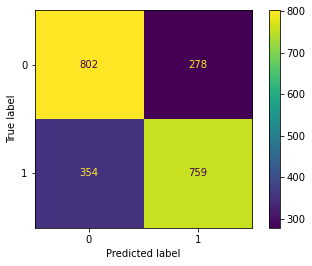

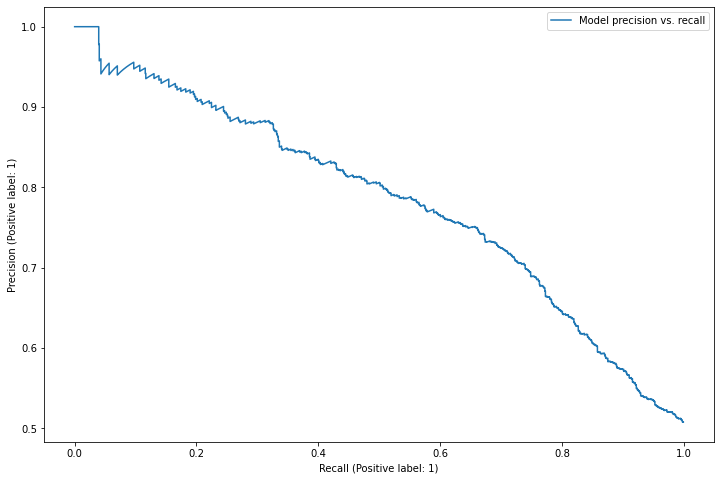

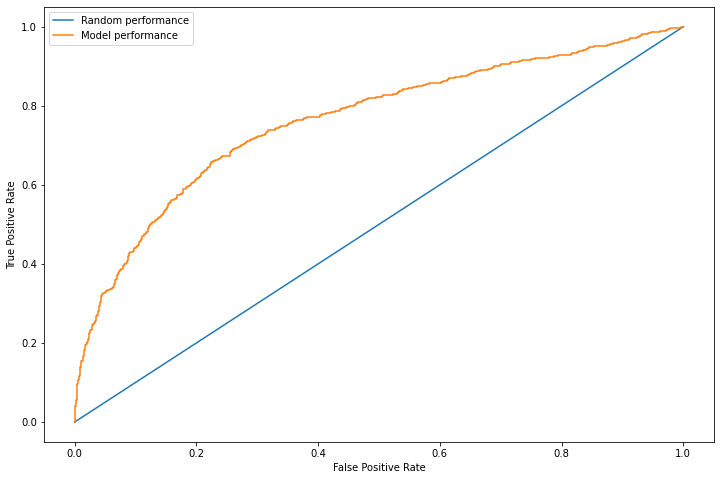

In [18]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [19]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Conv1D-stride1-undersampling' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Conv1D-stride1-undersampling20210602-2226


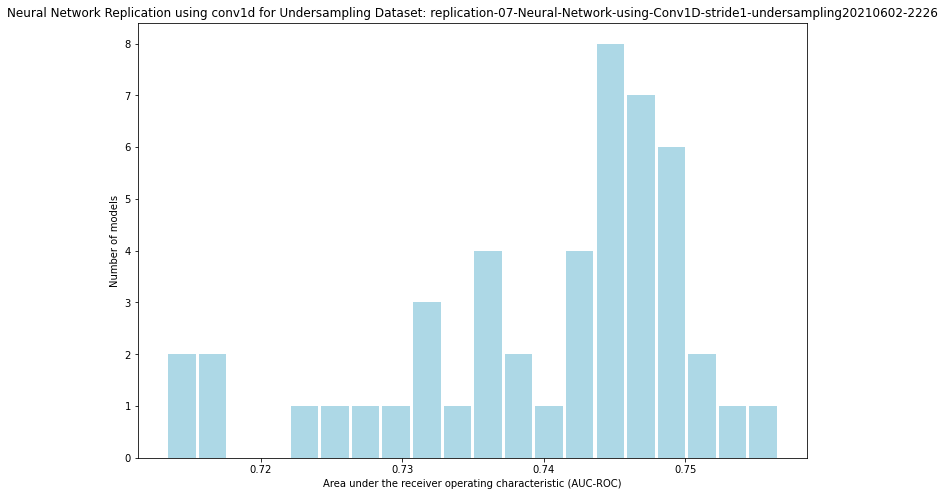

In [20]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using conv1d for Undersampling Dataset: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [21]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../DeepLearningResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)